In [1]:
# toc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from scipy.integrate import odeint

plt.style.use('../maroon_ipynb.mplstyle')

# Problem 1
## Given
A hydraulic power supply (comprising a motor-driven pump and a relief valve) has the pressure-flow characteristic plotted on the left below. It drives a positive displacement hydraulic motor which in turn rotates a shaft that drives some mechanical equipment. Frictional and leakage losses in the hydraulic motor may be neglected. The characteristics of the mechanical load are plotted on the right below.

![Figure 1](fig1.png)

## Find

a. Define key variables and place them on both the drawing and a bond-graph model of the system.
b. Find the maximum possible speed of the load.
c. Determine the volumetric displacement per revolution of the hydraulic motor.

## Solution
### Part A

![Figure 2](fig2.png)

In the above image, the source, $S$, causes a pressure difference, $P_s$, in the hydraulic rotary motor (the transformer $T$). This pressure difference causes a flow rate, $Q$, in the motor. The motor then induces a moment, $M_L$, on a shaft connected to the mechanical load, $R$. This in turn causes the load to rotate at a speed, $\omega$. The load also produces a resistant pressure, $P_L$, on the source. This ideal machine yields the following relationships:

$$P_s=TM_L$$
$$\omega=TQ$$

### Part B
We need to find the modulus that results in a maximum speed. This can be done by operating at the peak power of the source curve. First off, let's convert these graphs into functions. For the source curve, on inspection, you'll find that the relationship is linear:

$$P_s(Q)=18-0.06Q\ MPa$$

We need to ensure consistent units for the transformer modulus. This requires the pressure and flow rate to change to $Pa$ and $m^3/s$, respectively. Making this change, we get:

$$P_s(Q)=18\cdot10^6-6\cdot10^{10}Q\ Pa$$

This ensures that the units for the modulus come out to be $\frac{1}{m^3}$. For the load curve, this is a little more complicated. The curve can be approximated by a quadratic function that has been fitted to the data.

A: 0.002646604774363997, B: 0.04479742996739807, C: 0.5613276032319153


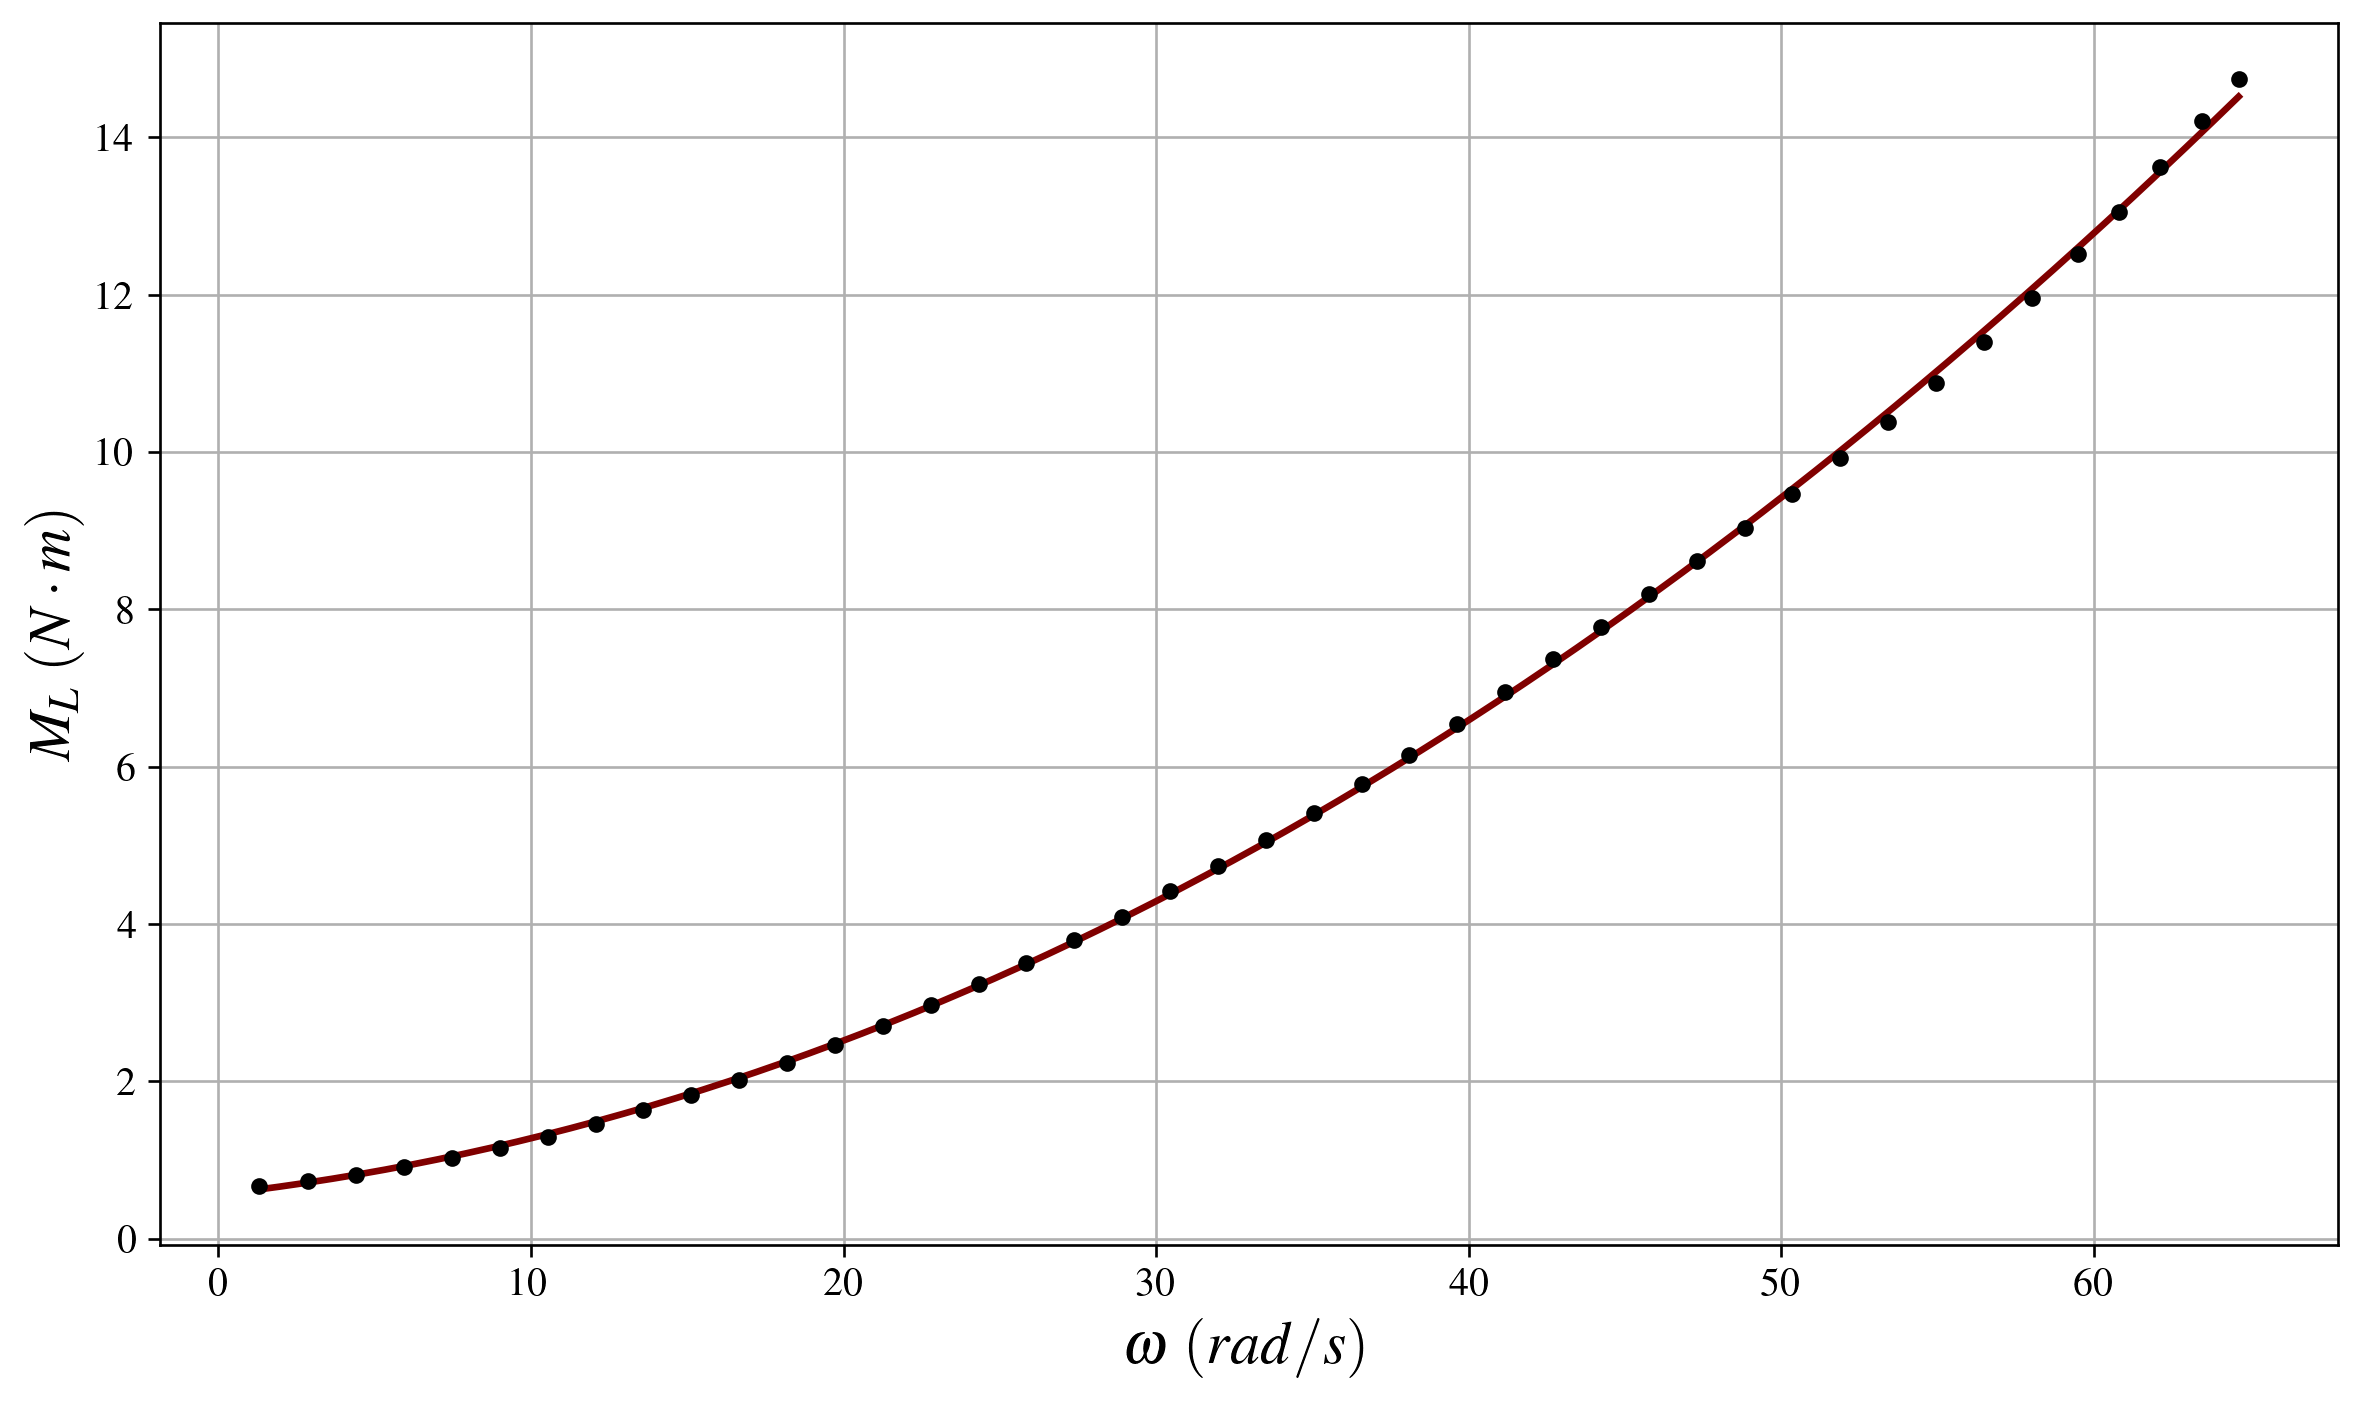

In [2]:
# Finding the best fit curve for the load data
data = pd.read_csv('p1_data.csv')
omegas = np.array(data['omega'])
torques = np.array(data['torque'])

A, B, C = np.polyfit(omegas, torques, 2)
print(f'A: {A}, B: {B}, C: {C}')

omega_array = np.linspace(omegas[0], omegas[-1], 300)
torque_array = A*omega_array**2 + B*omega_array + C

fig, ax = plt.subplots()
ax.scatter(omegas, torques, zorder=3, color='black', marker='.')
ax.plot(omega_array, torque_array)
ax.set_xlabel(r'$\omega$ $(rad/s)$')
ax.set_ylabel(r'$M_L$ $(N\cdot m)$')
plt.show()

This yields the following equation:

$$M_L(\omega)=0.00265\omega^2+0.0448\omega+0.561\ N\cdot m$$

Now we can find the peak power of the source curve where power is

$$\dot{E}=P_s\cdot Q$$

In [3]:
# Finding the peak power
Q = sp.Symbol('Q')
Ps = int(18e6) - int(6e10)*Q
E_dot = Ps*Q
E_dot

Q*(18000000 - 60000000000*Q)

In [4]:
E_dot_diff = E_dot.diff()
Q_max = sp.solve(E_dot_diff, Q)[0]
Q_max.n()  # m^3/s

0.000150000000000000

We have calculated that the ideal flow rate would be $0.00015\,m^3/s$, but this is not within the bounds of source operating conditions. Therefore, we will have to operate at the maximum possible flow rate, which is $0.00005\,m^3/s$, since this is the peak power of the source.

In [5]:
Q_max_power = 0.00005  # m^3/s
# Q_max_power = Q_max  # m^3/s

# Find the value of T at this flow rate
omega, T = sp.symbols('omega T')
M_L = A*omega**2 + B*omega + C
omega_ = T*Q
M_L_ = M_L.subs(omega, omega_)
eq = sp.Eq(Ps, T*M_L_)
eq

Eq(18000000 - 60000000000*Q, T*(0.002646604774364*Q**2*T**2 + 0.0447974299673981*Q*T + 0.561327603231915))

In [6]:
eq = eq.subs(Q, Q_max_power)
eq.simplify()

Eq(6.61651193590999e-12*T**3 + 2.2398714983699e-6*T**2 + 0.561327603231915*T, 15000000.0)

In [7]:
sol = sp.solve(eq, T)
sol

[1190301.78775134,
 -764414.663069025 - 1149032.59001054*I,
 -764414.663069025 + 1149032.59001054*I]

In [8]:
# Choose only the real solution
T_best = [T_val for T_val in sol if sp.im(T_val) == 0][0]
T_best  # 1/m^3

1190301.78775134

The transformer modulus of $T=1,190,302\,\frac{1}{m^3}$ produces the maximum power output that the source can provide. The corresponding load speed is

In [9]:
omega_max = T_best*Q_max_power
omega_max  # rad/s

59.5150893875669

If we plot the source curve with the load curve, we should see an equilibrium point at $Q_{max}=0.00005$. However, this load needs to be the load that acts on the source, $P_L$.

$$P_L=T\cdot M_L(\omega)=T\cdot M_L(T\cdot Q)$$

In [10]:
P_L = T_best*M_L.subs(omega, T_best*Q)
P_L.simplify()

4.46334388758242e+15*Q**2 + 63469820628.0566*Q + 668149.249641123

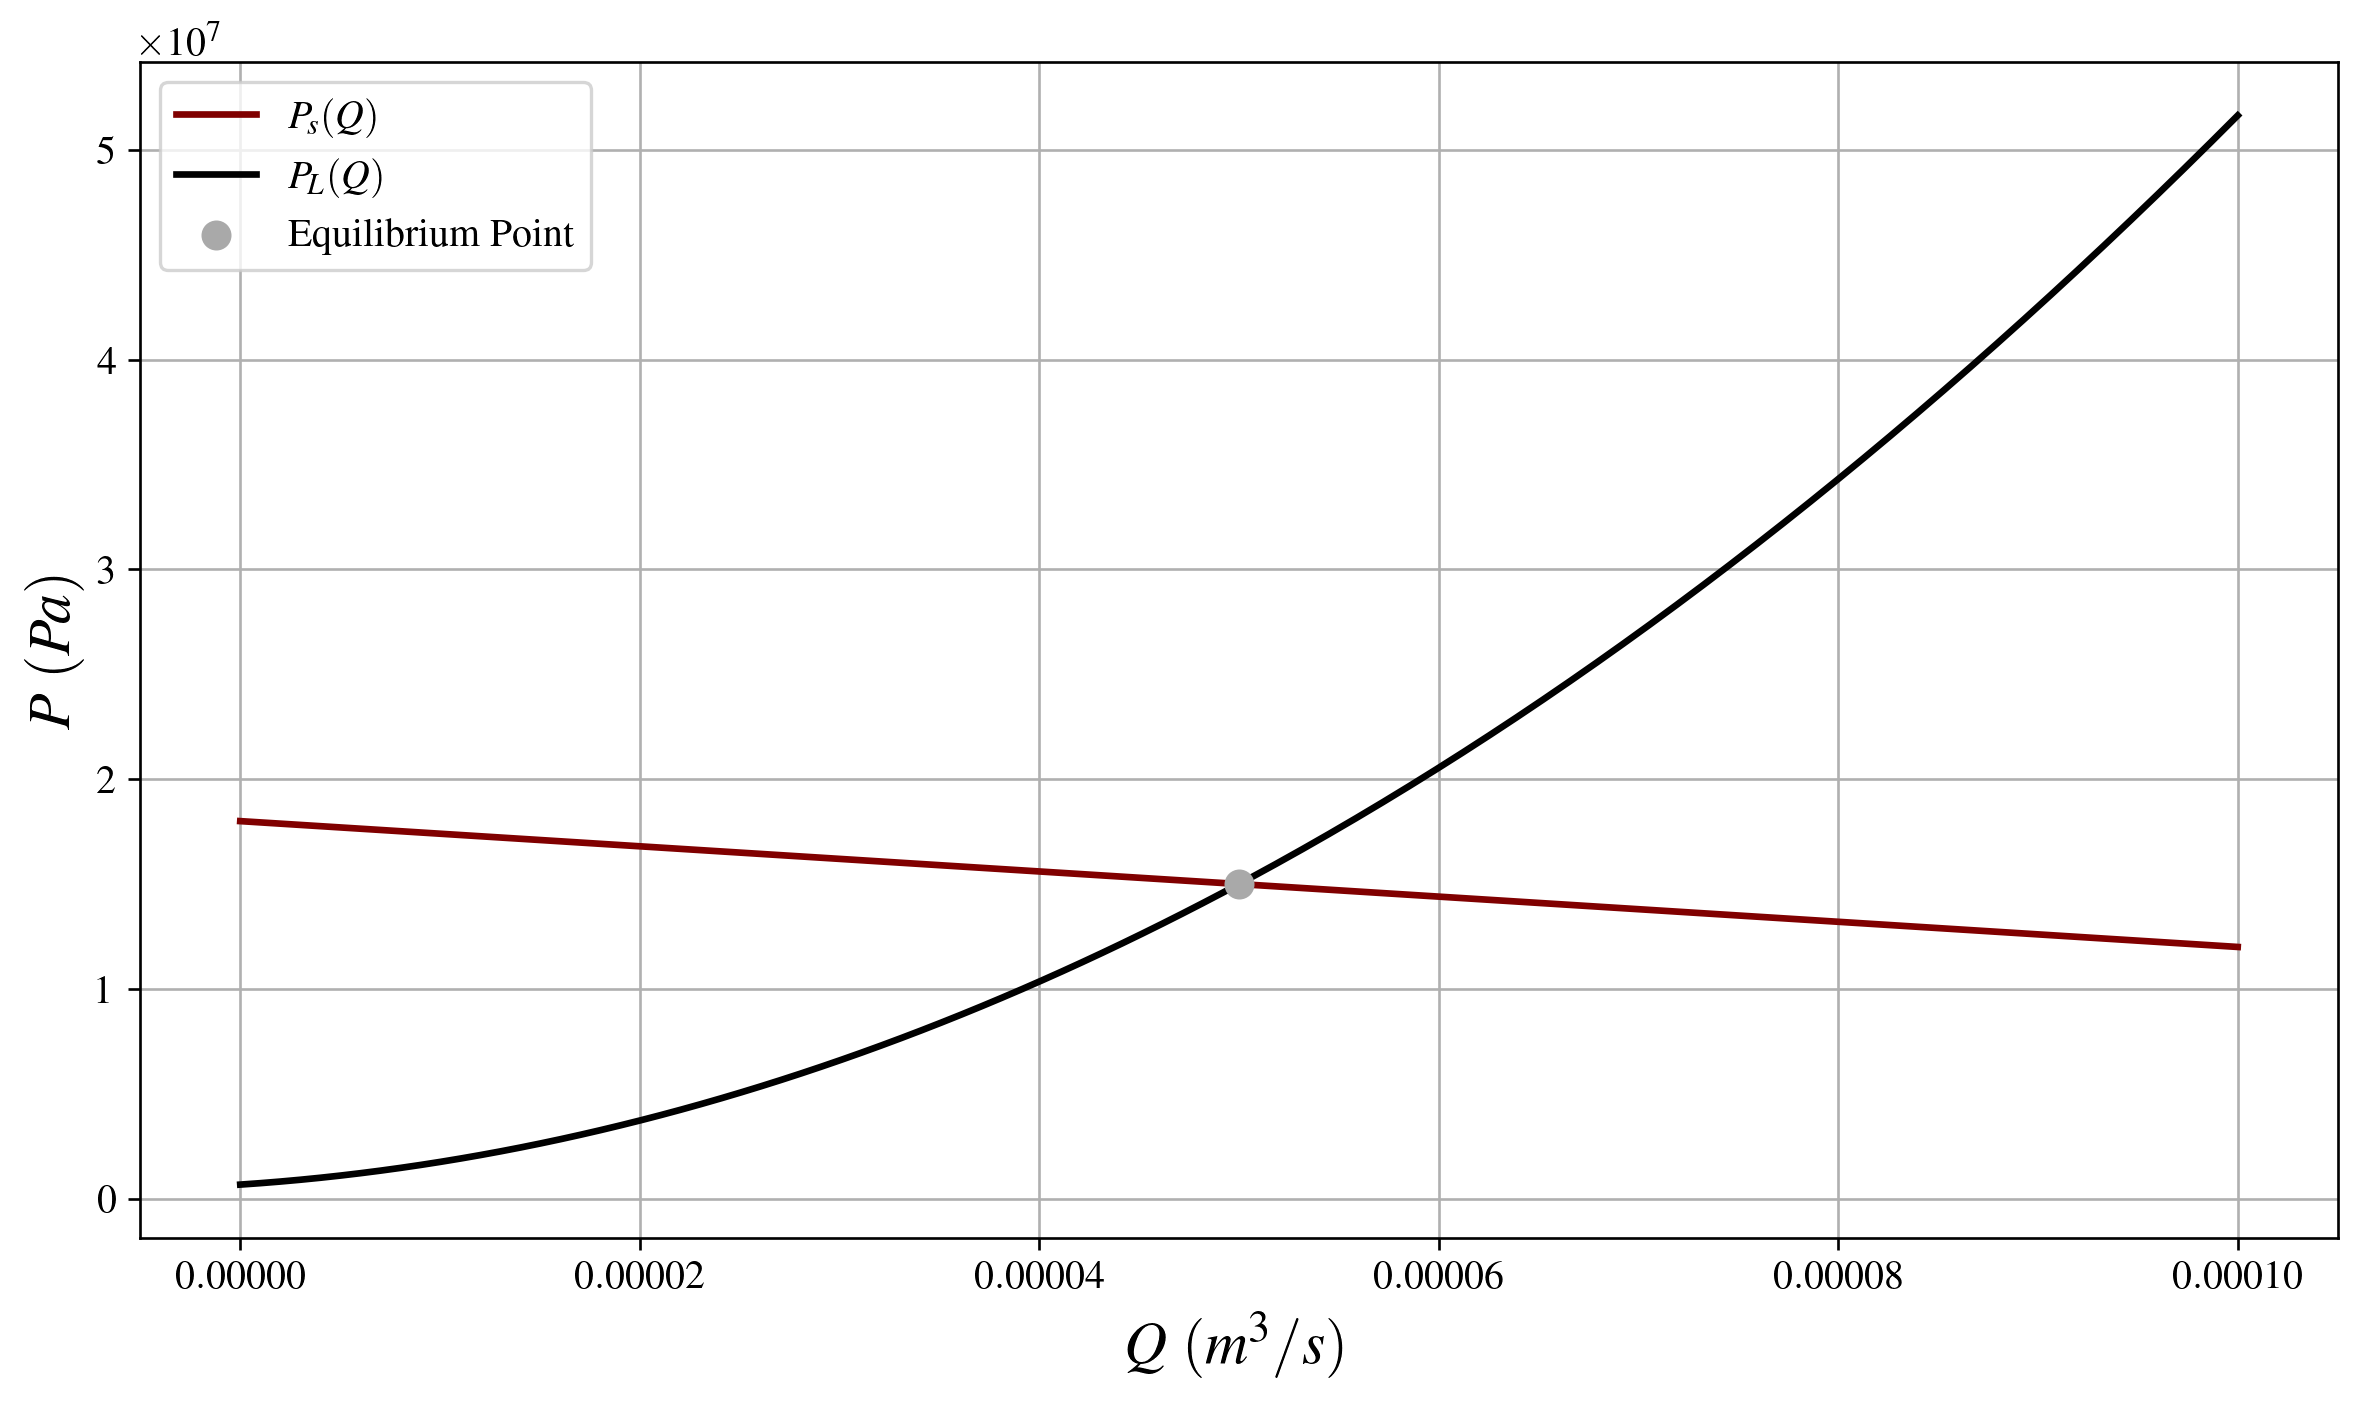

In [11]:
# Plotting
P_L_lamb = sp.lambdify(Q, P_L, modules='numpy')
Ps_lamb = sp.lambdify(Q, Ps, modules='numpy')

Q_array = np.linspace(0, float(Q_max_power)*2, 300)

fig, ax = plt.subplots()
ax.plot(Q_array, Ps_lamb(Q_array), label=r'$P_s(Q)$')
ax.plot(Q_array, P_L_lamb(Q_array), label=r'$P_L(Q)$')
ax.scatter(Q_max_power, Ps_lamb(Q_max_power), color='darkgrey', zorder=3, label='Equilibrium Point')
ax.set_xlabel('$Q$ $(m^3/s)$')
ax.set_ylabel('$P$ $(Pa)$')
ax.legend()
plt.show()

### Part C
The volumetric displacement per revolution would be

$$D=\frac{2\pi}{T}$$

which is just the reciprocal of the modulus. The $2\pi$ is the conversion factor from radians to revolutions.

In [12]:
D = 2*sp.pi/T_best
D.n(5)  # m^3/rev

5.2786e-6

## Verification
We can verify that this modulus results in the maximum speed by considering the speed, $\omega$, as a function of $T$.

In [13]:
eq1 = sp.Eq(Ps, T*M_L)
eq2 = sp.Eq(omega, T*Q)
display(eq1, eq2)

Eq(18000000 - 60000000000*Q, T*(0.002646604774364*omega**2 + 0.0447974299673981*omega + 0.561327603231915))

Eq(omega, Q*T)

In [14]:
Q_of_T_omega = sp.solve(eq1, Q)[0]
eq3 = eq2.subs(Q, Q_of_T_omega)
eq3

Eq(omega, T*(-4.41100795727333e-14*T*omega**2 - 7.46623832789968e-13*T*omega - 9.35546005386525e-12*T + 0.0003))

In [15]:
omega_of_T = sp.solve(eq3, omega, dict=True)
for sol in omega_of_T:
    for key, value in sol.items():
        display(sp.Eq(key, value).n(5))

Eq(omega, 2.2671e-14*(-3.7331e+14*T**2 - 5.0e+26*(-1.0932e-24*T**4 + 5.2932e-17*T**3 + 1.4932e-12*T**2 + 1.0)**0.5 - 5.0e+26)/T**2)

Eq(omega, 2.2671e-14*(-3.7331e+14*T**2 + 5.0e+26*(-1.0932e-24*T**4 + 5.2932e-17*T**3 + 1.4932e-12*T**2 + 1.0)**0.5 - 5.0e+26)/T**2)

Only one of these solutions should result in positive values of $\omega$ for positive values of $T$, and it's the second solution.

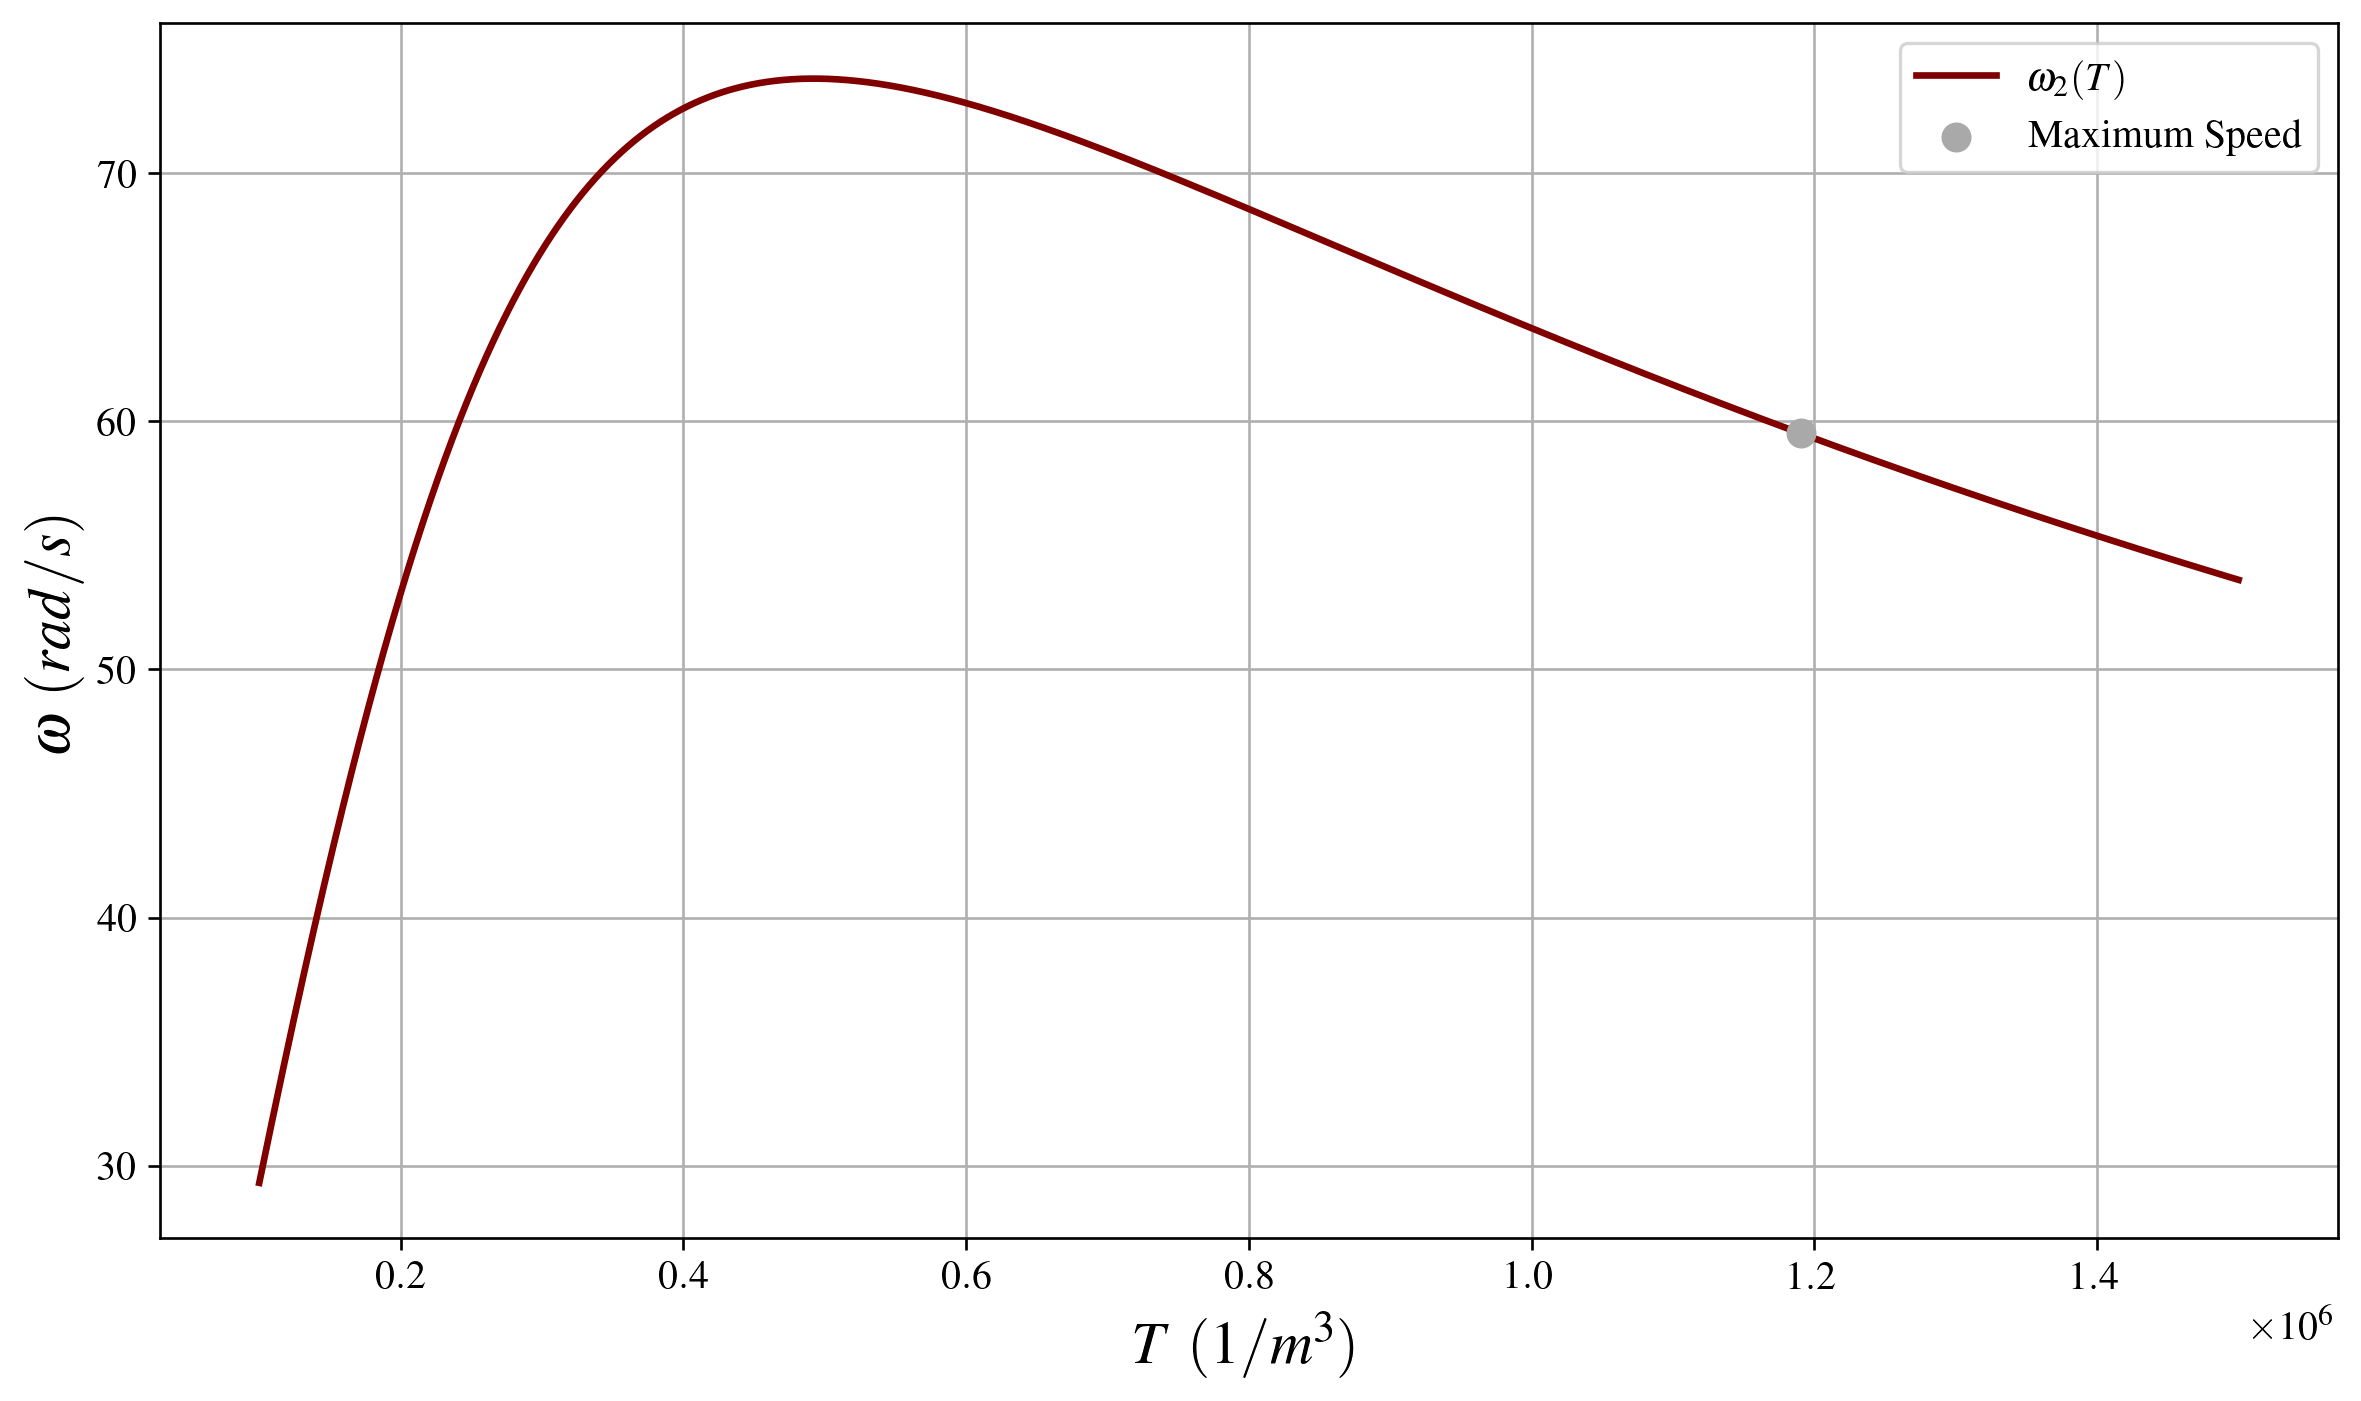

In [16]:
omega1, omega2 = omega_of_T[0][omega], omega_of_T[1][omega]
omega1_lamb, omega2_lamb = sp.lambdify(T, omega1, modules='numpy'), sp.lambdify(T, omega2, modules='numpy')

T_array = np.linspace(100_000, 1.5e6, 5000)
omega1_array, omega2_array = omega1_lamb(T_array), omega2_lamb(T_array)

fig, ax = plt.subplots()
# ax.plot(T_array, omega1_array, label=r'$\omega_1(T)$')
ax.plot(T_array, omega2_array, label=r'$\omega_2(T)$')
ax.set_xlabel(r'$T$ $(1/m^3)$')
ax.set_ylabel(r'$\omega$ $(rad/s)$')
ax.scatter(float(T_best), float(omega_max), color='darkgrey', zorder=3, label='Maximum Speed')
ax.legend()
plt.show()

If there was not a limitation on the source, then the best transformer modulus would be $T=492,104\,\frac{1}{m^3}$, resulting in a speed of $73.8\,rad/s$. However, this occurs at a flow rate of $Q_{max}=0.00015$, which is not within the operating conditions of the source. If you wanted to see the results without this limitation, then you can uncomment the line `Q_max_power = Q_max  # m^3/s` in the code cell 5.

You should also recognize that in order to get that dot to move to the left, you need to keep increasing the flow rate $Q$. Looking at the graph, you can see that the output shaft speed decreases with increasing modulus, so we can definitely say that this is the maximum speed.

# Problem 2
## Given

![Figure 3](fig3.png)

For the figure shown above assume the armature has a moment-speed curve of $M_a(\omega_1)=-315\omega_1+2000$ when the motor is on and acts as a damper when the motor is off with $M_a(\omega_1)=-14.4\omega_1$. In both cases the armature speed is in $rad/s$ and the moment is in $lbf\cdot in$.

Assume that all shafts are made of steel ($G=1.15\cdot10^7\,psi$) and that the diameter of the bevel gears is 2 inches. Model each shaft as a rotational spring $\left(k=\frac{\pi r^4G}{2L}\right)$. Model the resistance felt by each of the paddles (inertias 7 and 8 shown at the bottom of the industrial mixer) with rotational dampers of a coefficient of $B=2880\,lbf\cdot in\cdot s$. The number of teeth of each gear (20T, 12T, and 36T) is given in the figure.

## Find
Obtain the following:

a. A detailed free body diagram including your choice of reference coordinates.
b. A complete set of differential equations in state variable form. Notice that there are 8 inertias and 4 springs, but not all inertias are independent.
c. Solve the state variable equations using a 4th order Runge-Kutta method for a time period of 20 seconds. Assume that all initial states are zero and that the motor armature is on for the first 10 seconds and off for the last 10 seconds. It is recommended that a very small time step is used. Try $\Delta t=0.0005s$.
d. Verify using energy conservation and include a discussion on the results with the following points:
    - When the motor is turned on and at steady-state ($\omega_1$ is constant), does it operate at its maximum power?
    - Also, consider the mechanical failure modes that might occur with the plotted speed results.

## Solution
### Part A

![Figure 4](fig4.png)

The free body diagram drawn above has no combined mass, resulting in the lengthiest method to solve this problem.

### Part B

In [17]:
# Defining symbols
I0, I1, I2, I3, I4, I5, I6, I7 = sp.symbols('I0 I1 I2 I3 I4 I5 I6 I7')
k1, k2 = sp.symbols('k1 k2')
B = sp.Symbol('B')
F1, F2, F3 = sp.symbols('F1 F2 F3')
r1, r2, r3, r4, r5 = sp.symbols('r1 r2 r3 r4 r5')

# Defining functions
t = sp.Symbol('t')
th0, th1, th2, th3, th4, th5, th6, th7 = [sp.Function(fr'\theta_{i}')(t) for i in range(0, 8)]
# Ma = sp.Function('M_a')(th0.diff())
Ma = sp.Symbol('M_a')

# Defining the equations of motion
eq1 = sp.Eq(I0*th0.diff(t, 2), k1*(th1 - th0) + Ma)
eq2 = sp.Eq(I1*th1.diff(t, 2), k1*(th0 - th1) - F1*r1)
eq3 = sp.Eq(I2*th2.diff(t, 2), k1*(th3 - th2) + F1*r2)
eq4 = sp.Eq(I3*th3.diff(t, 2), k1*(th2 - th3) - F2*r3 - F3*r3)
eq5 = sp.Eq(I4*th4.diff(t, 2), k2*(th6 - th4) + F2*r4)
eq6 = sp.Eq(I5*th5.diff(t, 2), k2*(th7 - th5) + F3*r5)
eq7 = sp.Eq(I6*th6.diff(t, 2), k2*(th4 - th6) - B*th6.diff())
eq8 = sp.Eq(I7*th7.diff(t, 2), k2*(th5 - th7) - B*th7.diff())
eqs = [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]
display(*eqs)

Eq(I0*Derivative(\theta_0(t), (t, 2)), M_a + k1*(-\theta_0(t) + \theta_1(t)))

Eq(I1*Derivative(\theta_1(t), (t, 2)), -F1*r1 + k1*(\theta_0(t) - \theta_1(t)))

Eq(I2*Derivative(\theta_2(t), (t, 2)), F1*r2 + k1*(-\theta_2(t) + \theta_3(t)))

Eq(I3*Derivative(\theta_3(t), (t, 2)), -F2*r3 - F3*r3 + k1*(\theta_2(t) - \theta_3(t)))

Eq(I4*Derivative(\theta_4(t), (t, 2)), F2*r4 + k2*(-\theta_4(t) + \theta_6(t)))

Eq(I5*Derivative(\theta_5(t), (t, 2)), F3*r5 + k2*(-\theta_5(t) + \theta_7(t)))

Eq(I6*Derivative(\theta_6(t), (t, 2)), -B*Derivative(\theta_6(t), t) + k2*(\theta_4(t) - \theta_6(t)))

Eq(I7*Derivative(\theta_7(t), (t, 2)), -B*Derivative(\theta_7(t), t) + k2*(\theta_5(t) - \theta_7(t)))

We essentially have 11 unknowns (the $\theta$'s and reaction forces $F_1$, $F_2$, and $F_3$) and 8 equations. We can use the velocity ratios to add the additionally 3 equations.

In [18]:
eq9 = sp.Eq(th2.diff(t, 2), th1.diff(t, 2)*r1/r2)
eq10 = sp.Eq(th4.diff(t, 2), th3.diff(t, 2)*r3/r4)
eq11 = sp.Eq(th5.diff(t, 2), th3.diff(t, 2)*r3/r5)
eqs = eqs + [eq9, eq10, eq11]
display(eq9, eq10, eq11)

Eq(Derivative(\theta_2(t), (t, 2)), r1*Derivative(\theta_1(t), (t, 2))/r2)

Eq(Derivative(\theta_4(t), (t, 2)), r3*Derivative(\theta_3(t), (t, 2))/r4)

Eq(Derivative(\theta_5(t), (t, 2)), r3*Derivative(\theta_3(t), (t, 2))/r5)

In [19]:
# Solving the equations
eqs = eqs + [
    sp.Eq(r1, r2),
    sp.Eq(r3, sp.Rational(1, 3)*r4),
    sp.Eq(r3, sp.Rational(1, 3)*r5)
]
sol = sp.solve(
    eqs,
    (th0.diff(t, 2), th1.diff(t, 2), th2.diff(t, 2), th3.diff(t, 2), th4.diff(t, 2), th5.diff(t, 2), th6.diff(t, 2), th7.diff(t, 2), F1, F2, F3, r1, r2, r3, r4, r5),
    dict=True
)[0]

subs = [
    (th1, th2),
    (th4, sp.Rational(1, 3)*th3),
    (th5, sp.Rational(1, 3)*th3)
]

for key, value in sol.items():
    if key not in [F1, F2, F3, r1, r2, r3, r4, r5]:
        display(sp.Eq(key, value.subs(subs).simplify()))

Eq(Derivative(\theta_0(t), (t, 2)), (M_a - k1*\theta_0(t) + k1*\theta_2(t))/I0)

Eq(Derivative(\theta_1(t), (t, 2)), k1*(\theta_0(t) - 2*\theta_2(t) + \theta_3(t))/(I1 + I2))

Eq(Derivative(\theta_2(t), (t, 2)), k1*(\theta_0(t) - 2*\theta_2(t) + \theta_3(t))/(I1 + I2))

Eq(Derivative(\theta_3(t), (t, 2)), (9*k1*\theta_2(t) - 9*k1*\theta_3(t) - 2*k2*\theta_3(t) + 3*k2*\theta_6(t) + 3*k2*\theta_7(t))/(9*I3 + I4 + I5))

Eq(Derivative(\theta_4(t), (t, 2)), (3*k1*\theta_2(t) - 3*k1*\theta_3(t) - 2*k2*\theta_3(t)/3 + k2*\theta_6(t) + k2*\theta_7(t))/(9*I3 + I4 + I5))

Eq(Derivative(\theta_5(t), (t, 2)), (3*k1*\theta_2(t) - 3*k1*\theta_3(t) - 2*k2*\theta_3(t)/3 + k2*\theta_6(t) + k2*\theta_7(t))/(9*I3 + I4 + I5))

Eq(Derivative(\theta_6(t), (t, 2)), (-B*Derivative(\theta_6(t), t) + k2*\theta_3(t)/3 - k2*\theta_6(t))/I6)

Eq(Derivative(\theta_7(t), (t, 2)), (-B*Derivative(\theta_7(t), t) + k2*\theta_3(t)/3 - k2*\theta_7(t))/I7)

In the above equations, we see that there are a couple of redundancies. Since we coupled $\theta_4$ and $\theta_5$ with $\theta_3$, we can ignore the equations for $\theta_4$ and $\theta_5$. Similarly, we can only use $\theta_2$ since I decided to represent $\theta_1$ in terms of $\theta_2$. Notice that the equations for $\theta_6$ and $\theta_7$ can be proven to be the same, but if there was a different gear ratio, then these equations would be different, so I will choose to solve these equations independently for the possibility of considering a different ratio. This results in the following state variable equations:

In [20]:
# Grab only the equations we want
eq1 = sp.Eq(th0.diff(t, 2), sol[th0.diff(t, 2)].subs(subs).simplify())
eq2 = sp.Eq(th2.diff(t, 2), sol[th2.diff(t, 2)].subs(subs).simplify())
eq3 = sp.Eq(th3.diff(t, 2), sol[th3.diff(t, 2)].subs(subs).simplify())
eq4 = sp.Eq(th6.diff(t, 2), sol[th6.diff(t, 2)].subs(subs).simplify())
eq5 = sp.Eq(th7.diff(t, 2), sol[th7.diff(t, 2)].subs(subs).simplify())
eq_motion = [eq1, eq2, eq3, eq4, eq5]

# Define new state variables
th8, th9, th10, th11, th12 = [sp.Function(fr'\theta_{i}')(t) for i in range(8, 13)]

eq6 = sp.Eq(th0.diff(), th8)
eq7 = sp.Eq(th2.diff(), th9)
eq8 = sp.Eq(th3.diff(), th10)
eq9 = sp.Eq(th6.diff(), th11)
eq10 = sp.Eq(th7.diff(), th12)
state_eqs = [eq6, eq7, eq8, eq9, eq10]

# Make the substitutions of the state variables
state_subs = [
    (eq.lhs, eq.rhs) for eq in state_eqs
]
eq_motion = [eq.subs(state_subs) for eq in eq_motion]

state_sol = sp.solve(
    eq_motion + state_eqs,
    (th0.diff(), th2.diff(), th3.diff(), th6.diff(), th7.diff(), th8.diff(), th9.diff(), th10.diff(), th11.diff(), th12.diff()),
    dict=True
)[0]

# sympy is giving me an undesired order in the solution. I'll force it to display this order
sol_order = [th0.diff(), th2.diff(), th3.diff(), th6.diff(), th7.diff(), th8.diff(), th9.diff(), th10.diff(), th11.diff(), th12.diff()]

final_eq = []
for key in sol_order:
    eq = sp.Eq(key, state_sol[key].simplify())
    final_eq.append(eq)
    display(eq)

Eq(Derivative(\theta_0(t), t), \theta_8(t))

Eq(Derivative(\theta_2(t), t), \theta_9(t))

Eq(Derivative(\theta_3(t), t), \theta_10(t))

Eq(Derivative(\theta_6(t), t), \theta_11(t))

Eq(Derivative(\theta_7(t), t), \theta_12(t))

Eq(Derivative(\theta_8(t), t), (M_a - k1*\theta_0(t) + k1*\theta_2(t))/I0)

Eq(Derivative(\theta_9(t), t), k1*(\theta_0(t) - 2*\theta_2(t) + \theta_3(t))/(I1 + I2))

Eq(Derivative(\theta_10(t), t), (9*k1*\theta_2(t) - 9*k1*\theta_3(t) - 2*k2*\theta_3(t) + 3*k2*\theta_6(t) + 3*k2*\theta_7(t))/(9*I3 + I4 + I5))

Eq(Derivative(\theta_11(t), t), (-B*\theta_11(t) + k2*\theta_3(t)/3 - k2*\theta_6(t))/I6)

Eq(Derivative(\theta_12(t), t), (-B*\theta_12(t) + k2*\theta_3(t)/3 - k2*\theta_7(t))/I7)

You can easily convert this to the matrix form with `sympy`'s `linear_eq_to_matrix` function.

In [21]:
# Converting to matrix form
x = [th0, th2, th3, th6, th7, th8, th9, th10, th11, th12]
rhs_values = [eq.rhs for eq in final_eq]
A, b = sp.linear_eq_to_matrix(rhs_values, x)
mat_eq = sp.Eq(sp.Matrix(sol_order), sp.Add(sp.MatMul(A, sp.Matrix(x)), -b))
mat_eq

Eq(Matrix([
[ Derivative(\theta_0(t), t)],
[ Derivative(\theta_2(t), t)],
[ Derivative(\theta_3(t), t)],
[ Derivative(\theta_6(t), t)],
[ Derivative(\theta_7(t), t)],
[ Derivative(\theta_8(t), t)],
[ Derivative(\theta_9(t), t)],
[Derivative(\theta_10(t), t)],
[Derivative(\theta_11(t), t)],
[Derivative(\theta_12(t), t)]]), Matrix([
[     0],
[     0],
[     0],
[     0],
[     0],
[M_a/I0],
[     0],
[     0],
[     0],
[     0]]) + Matrix([
[           0,                     0,                               0,                     0,                     0, 1, 0, 0,     0,     0],
[           0,                     0,                               0,                     0,                     0, 0, 1, 0,     0,     0],
[           0,                     0,                               0,                     0,                     0, 0, 0, 1,     0,     0],
[           0,                     0,                               0,                     0,                     0, 0, 0, 0,     1,

In [22]:
mat_eq.doit()

Eq(Matrix([
[ Derivative(\theta_0(t), t)],
[ Derivative(\theta_2(t), t)],
[ Derivative(\theta_3(t), t)],
[ Derivative(\theta_6(t), t)],
[ Derivative(\theta_7(t), t)],
[ Derivative(\theta_8(t), t)],
[ Derivative(\theta_9(t), t)],
[Derivative(\theta_10(t), t)],
[Derivative(\theta_11(t), t)],
[Derivative(\theta_12(t), t)]]), Matrix([
[                                                                                                                                            \theta_8(t)],
[                                                                                                                                            \theta_9(t)],
[                                                                                                                                           \theta_10(t)],
[                                                                                                                                           \theta_11(t)],
[                                              

### Part C
I will now bring this to the numerical world with a python function. There is a way to automate this and actually use the expressions given by `sympy`, but for clarity, I will not do this.

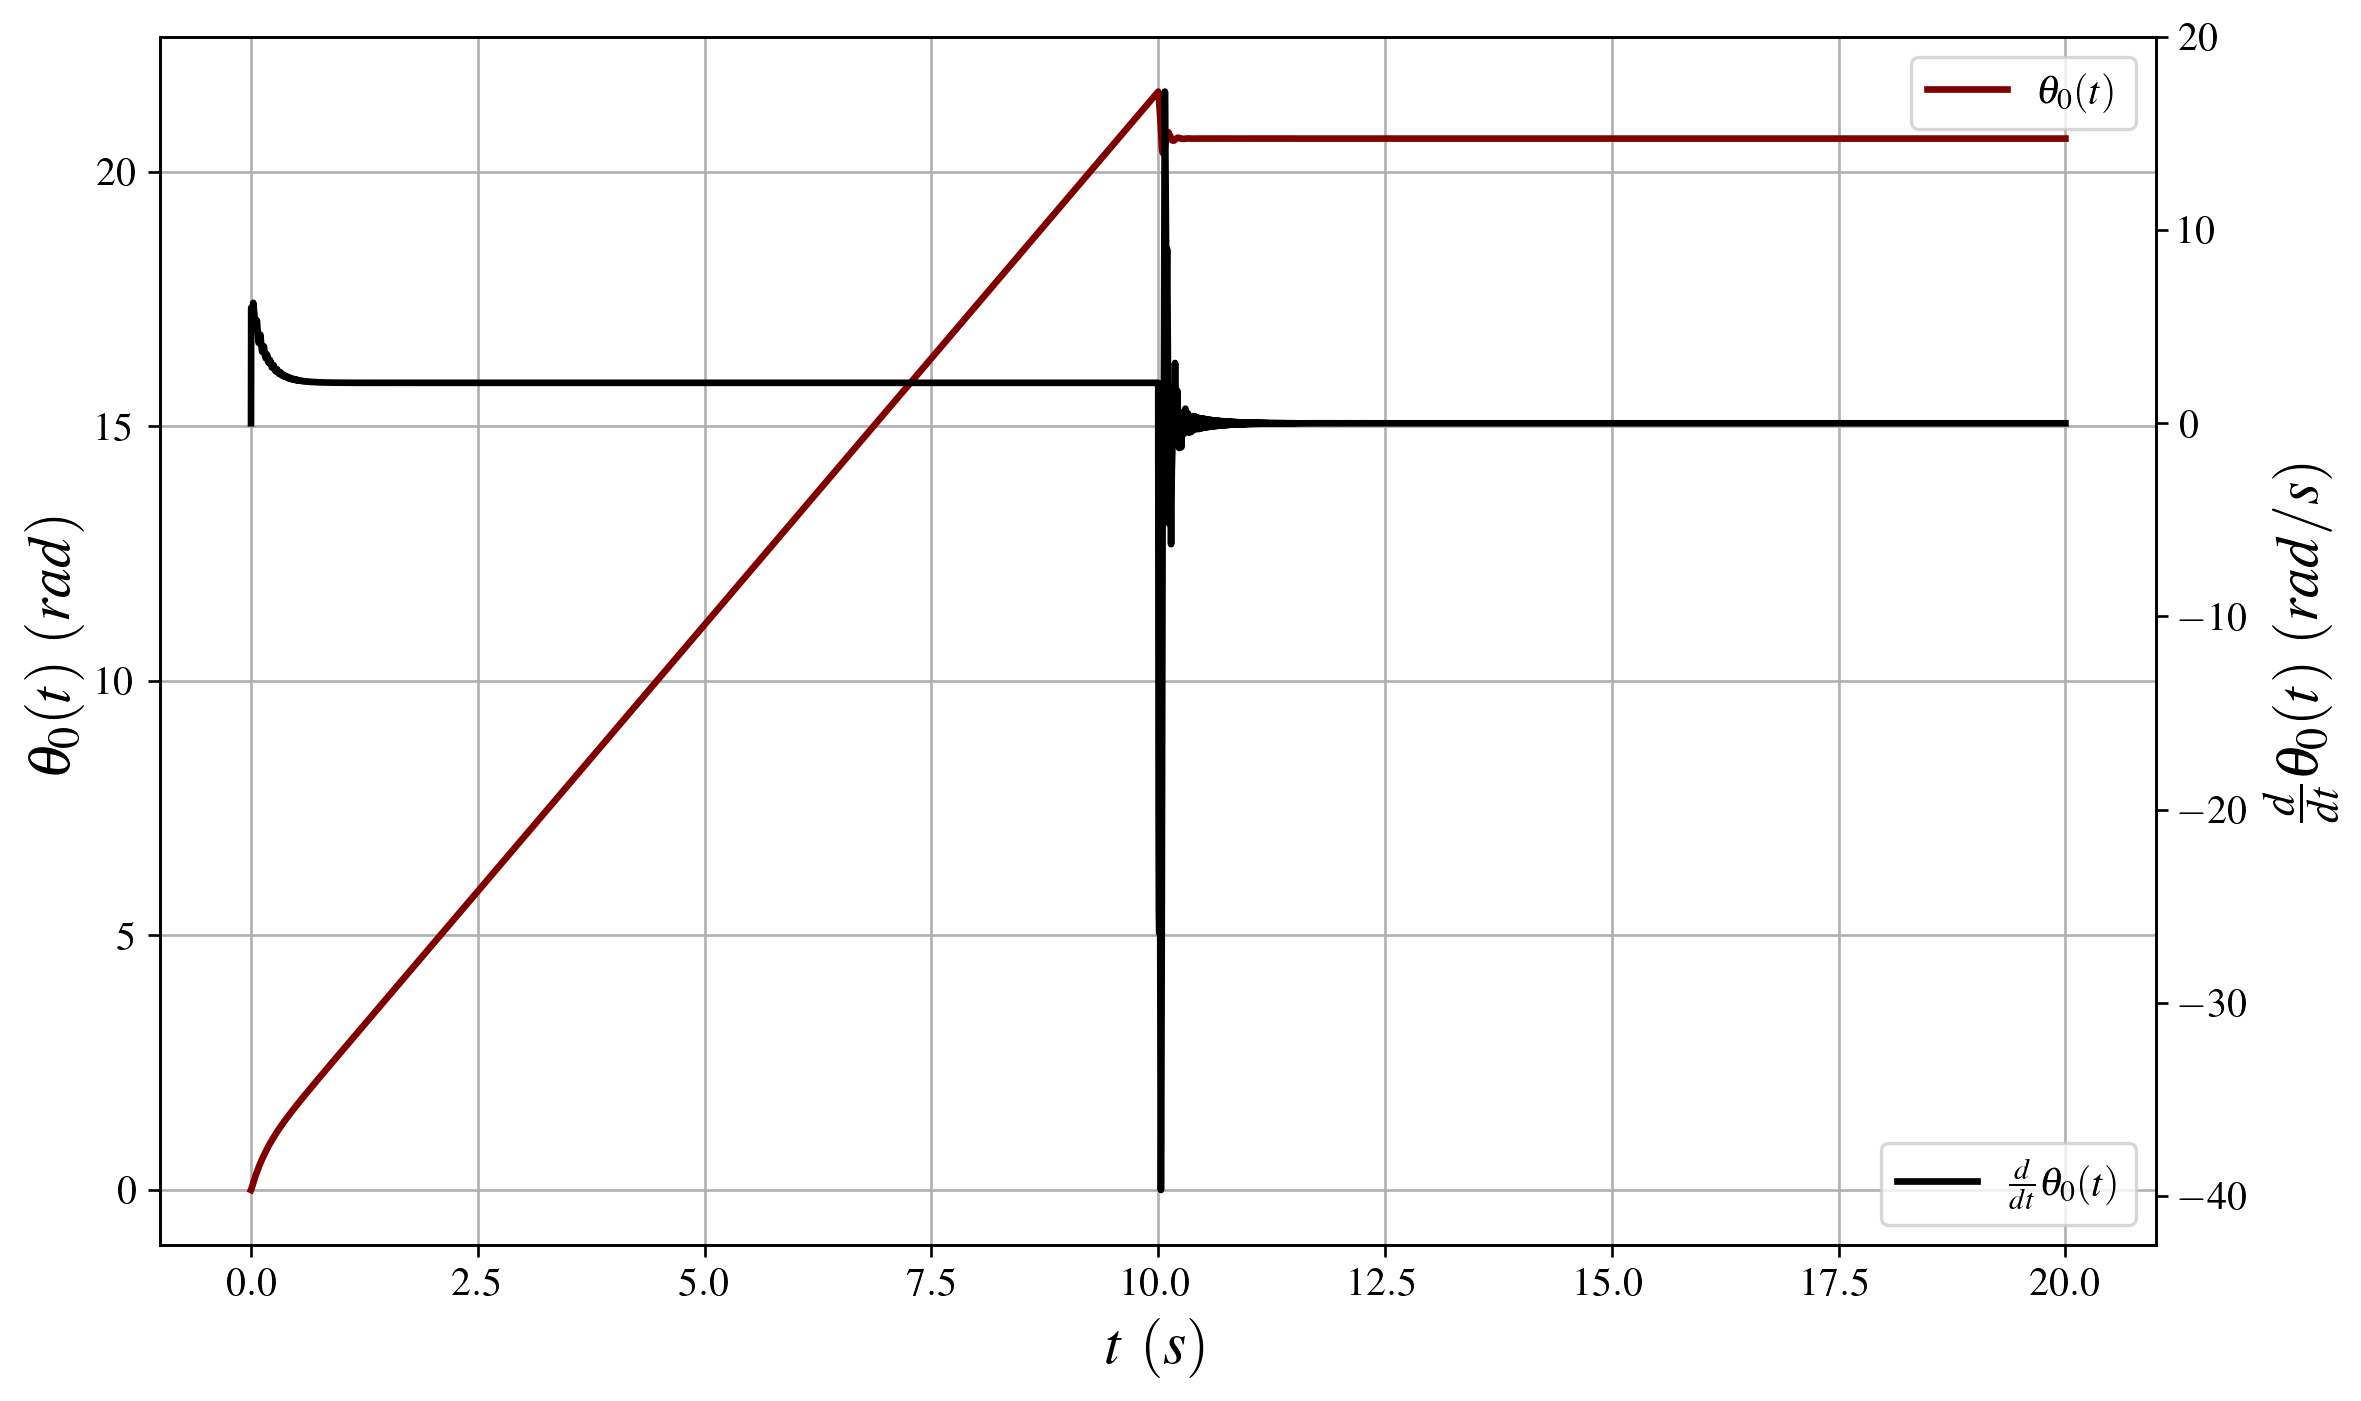

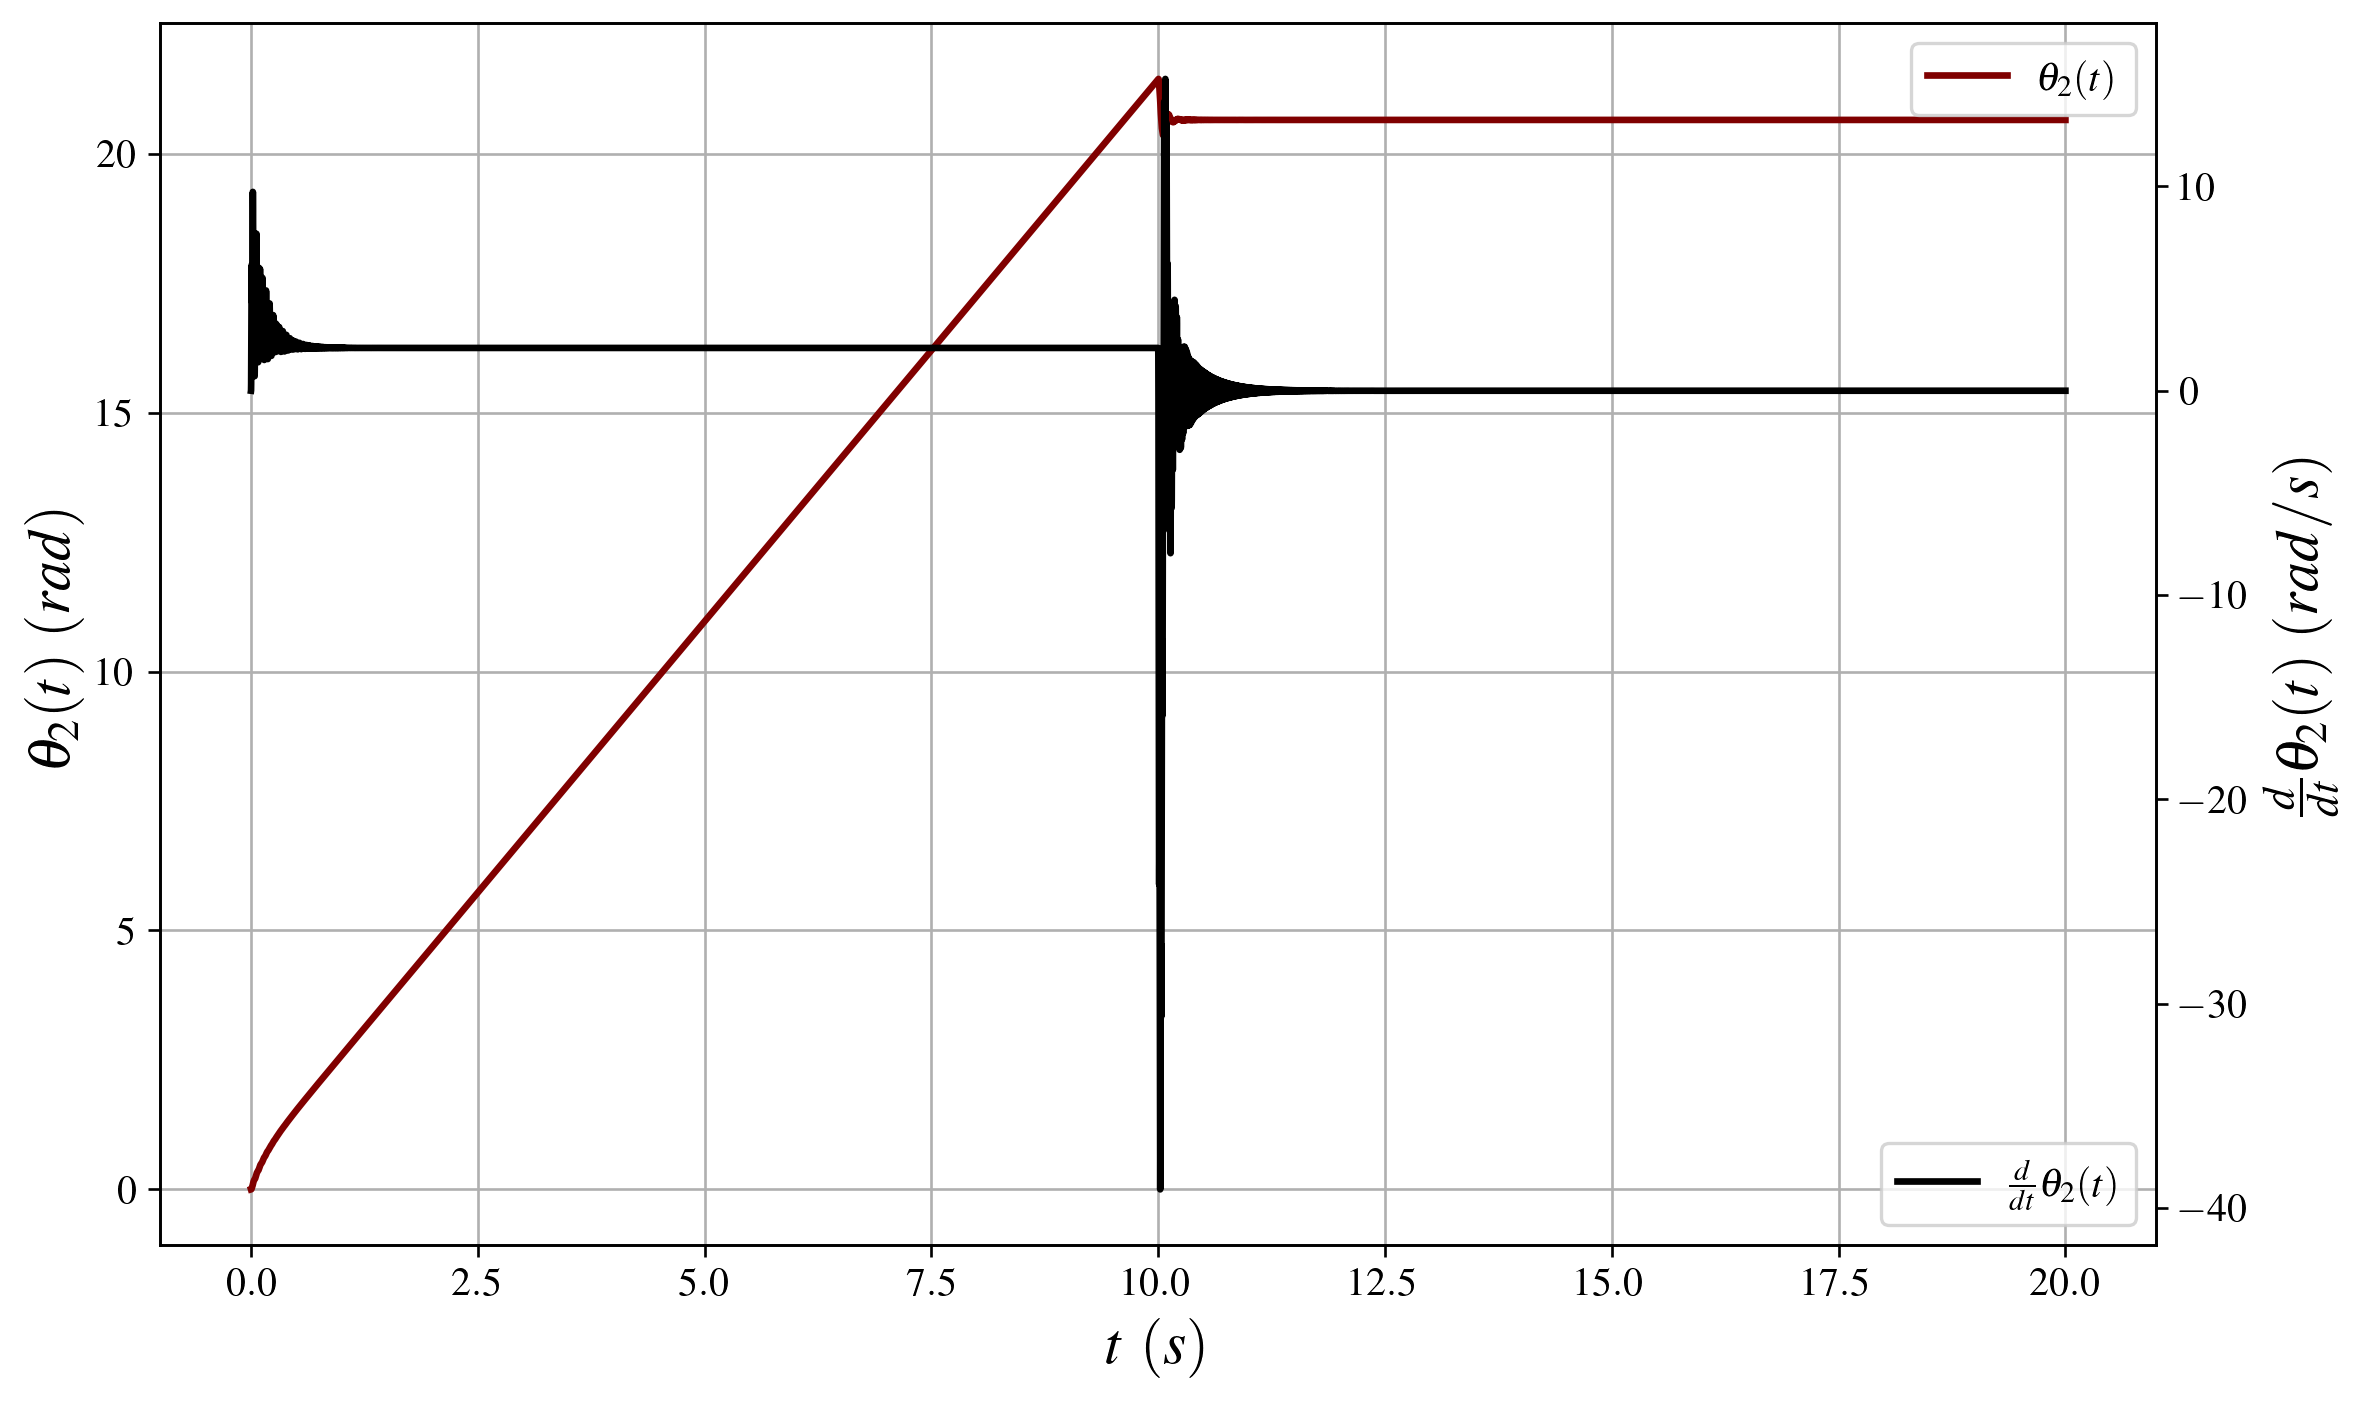

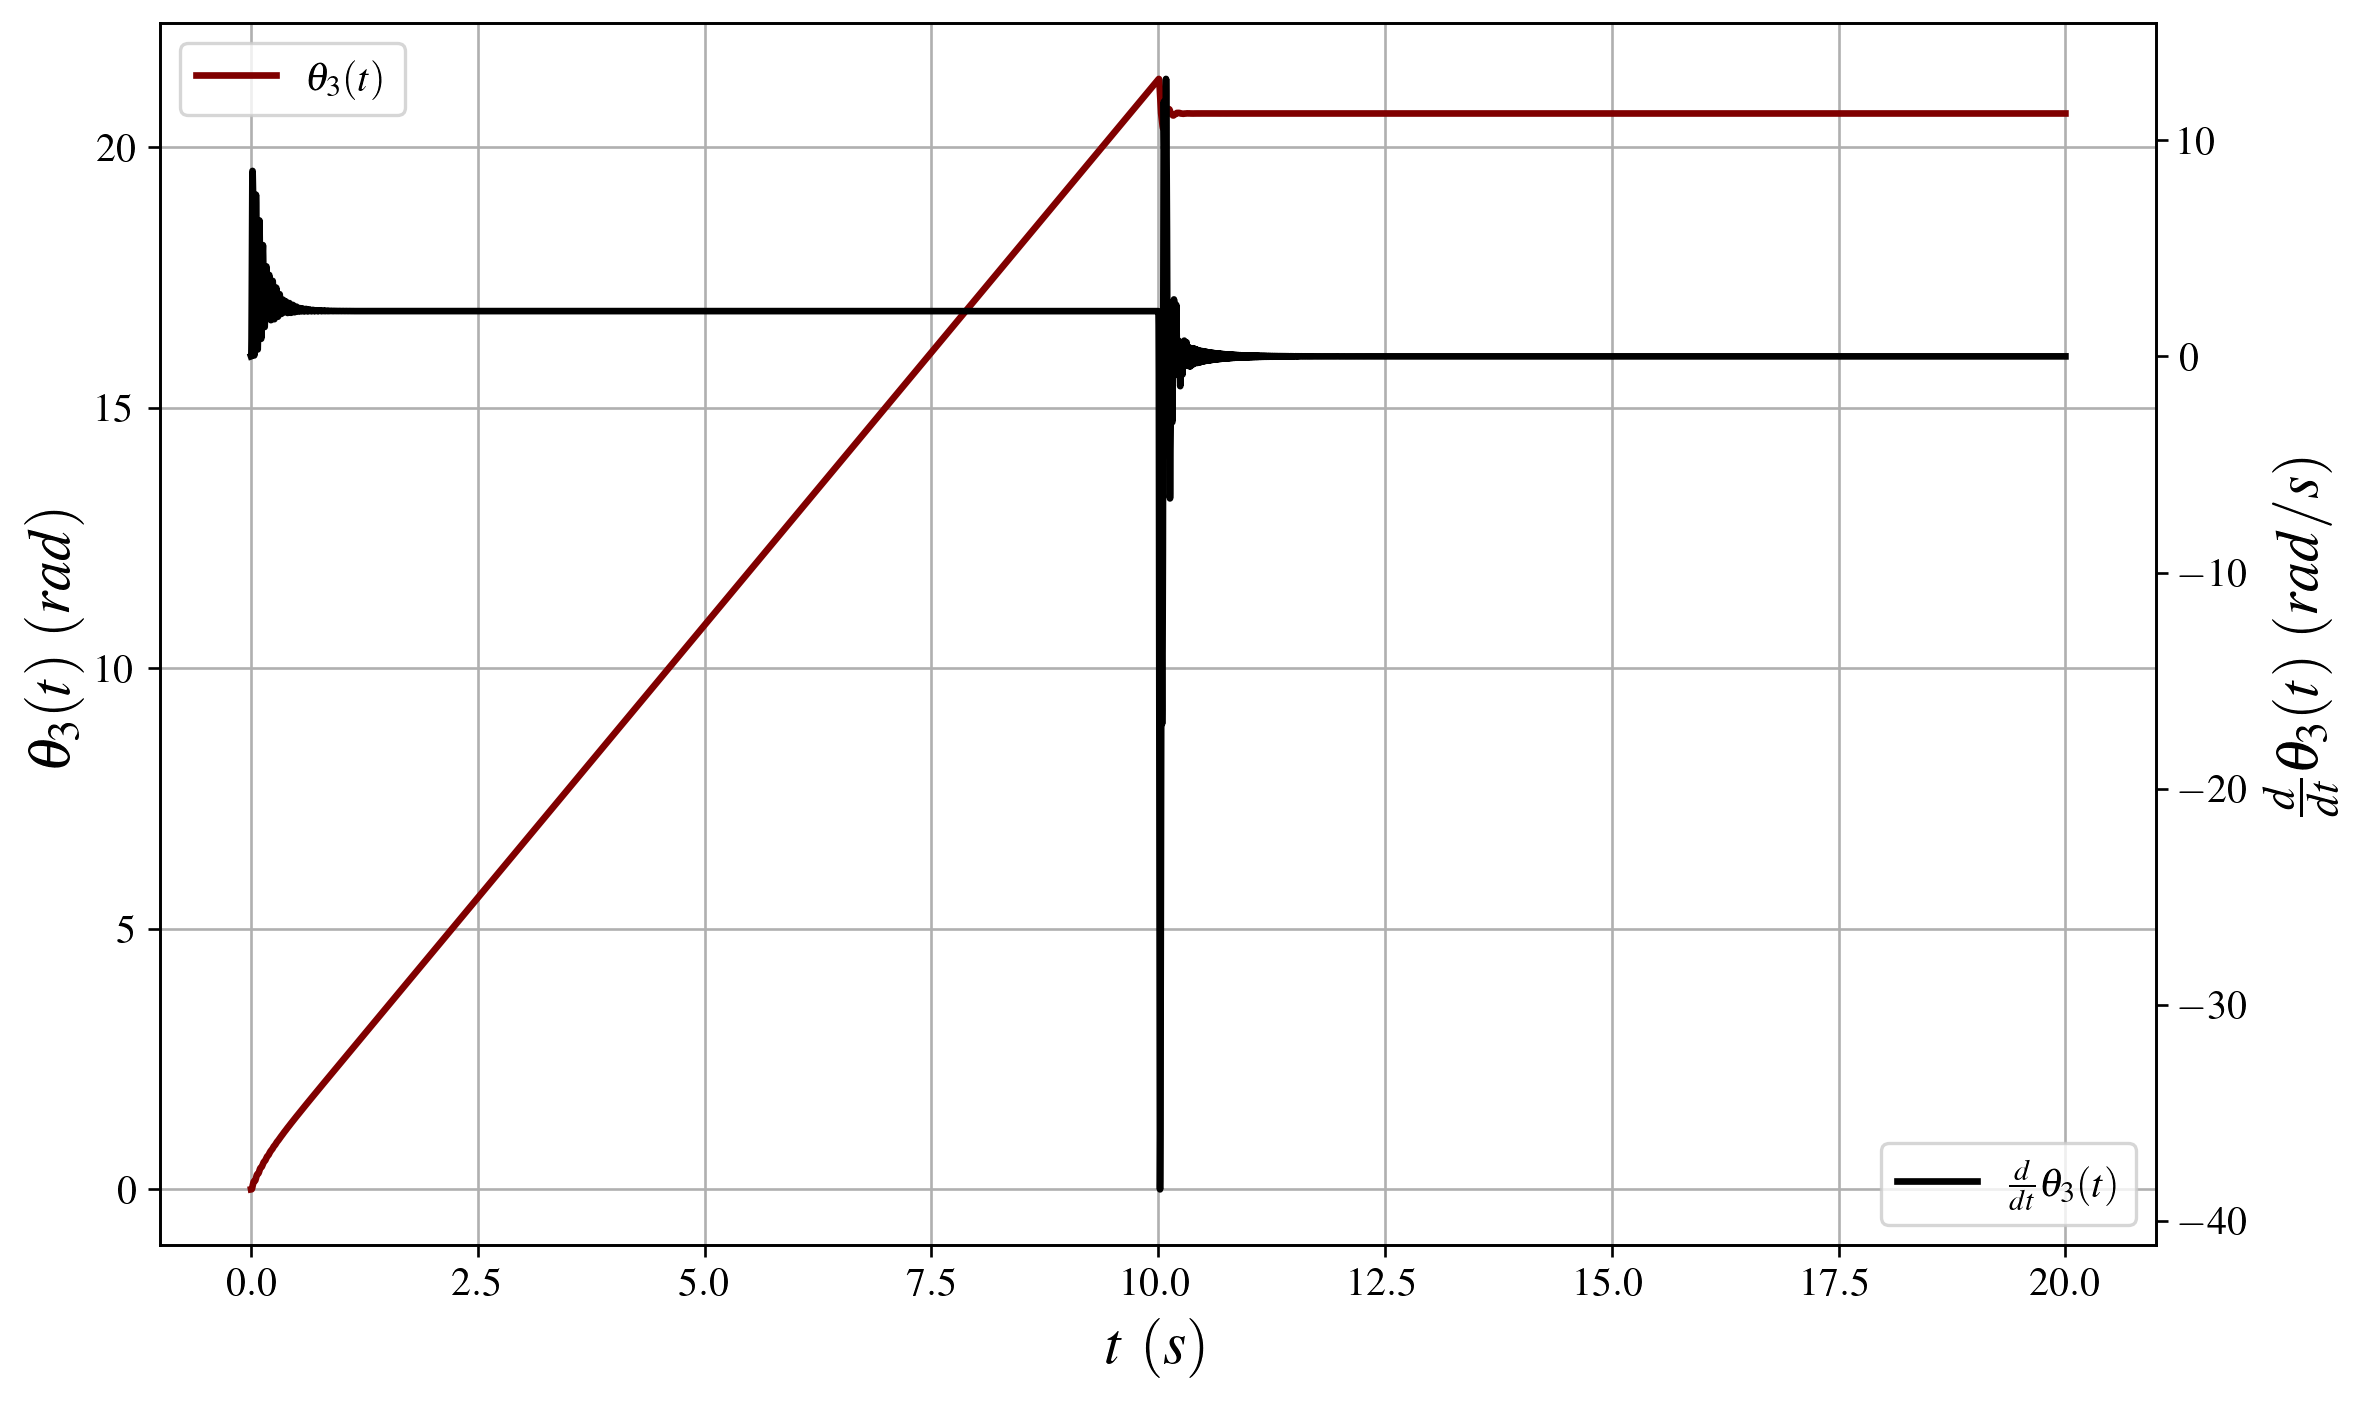

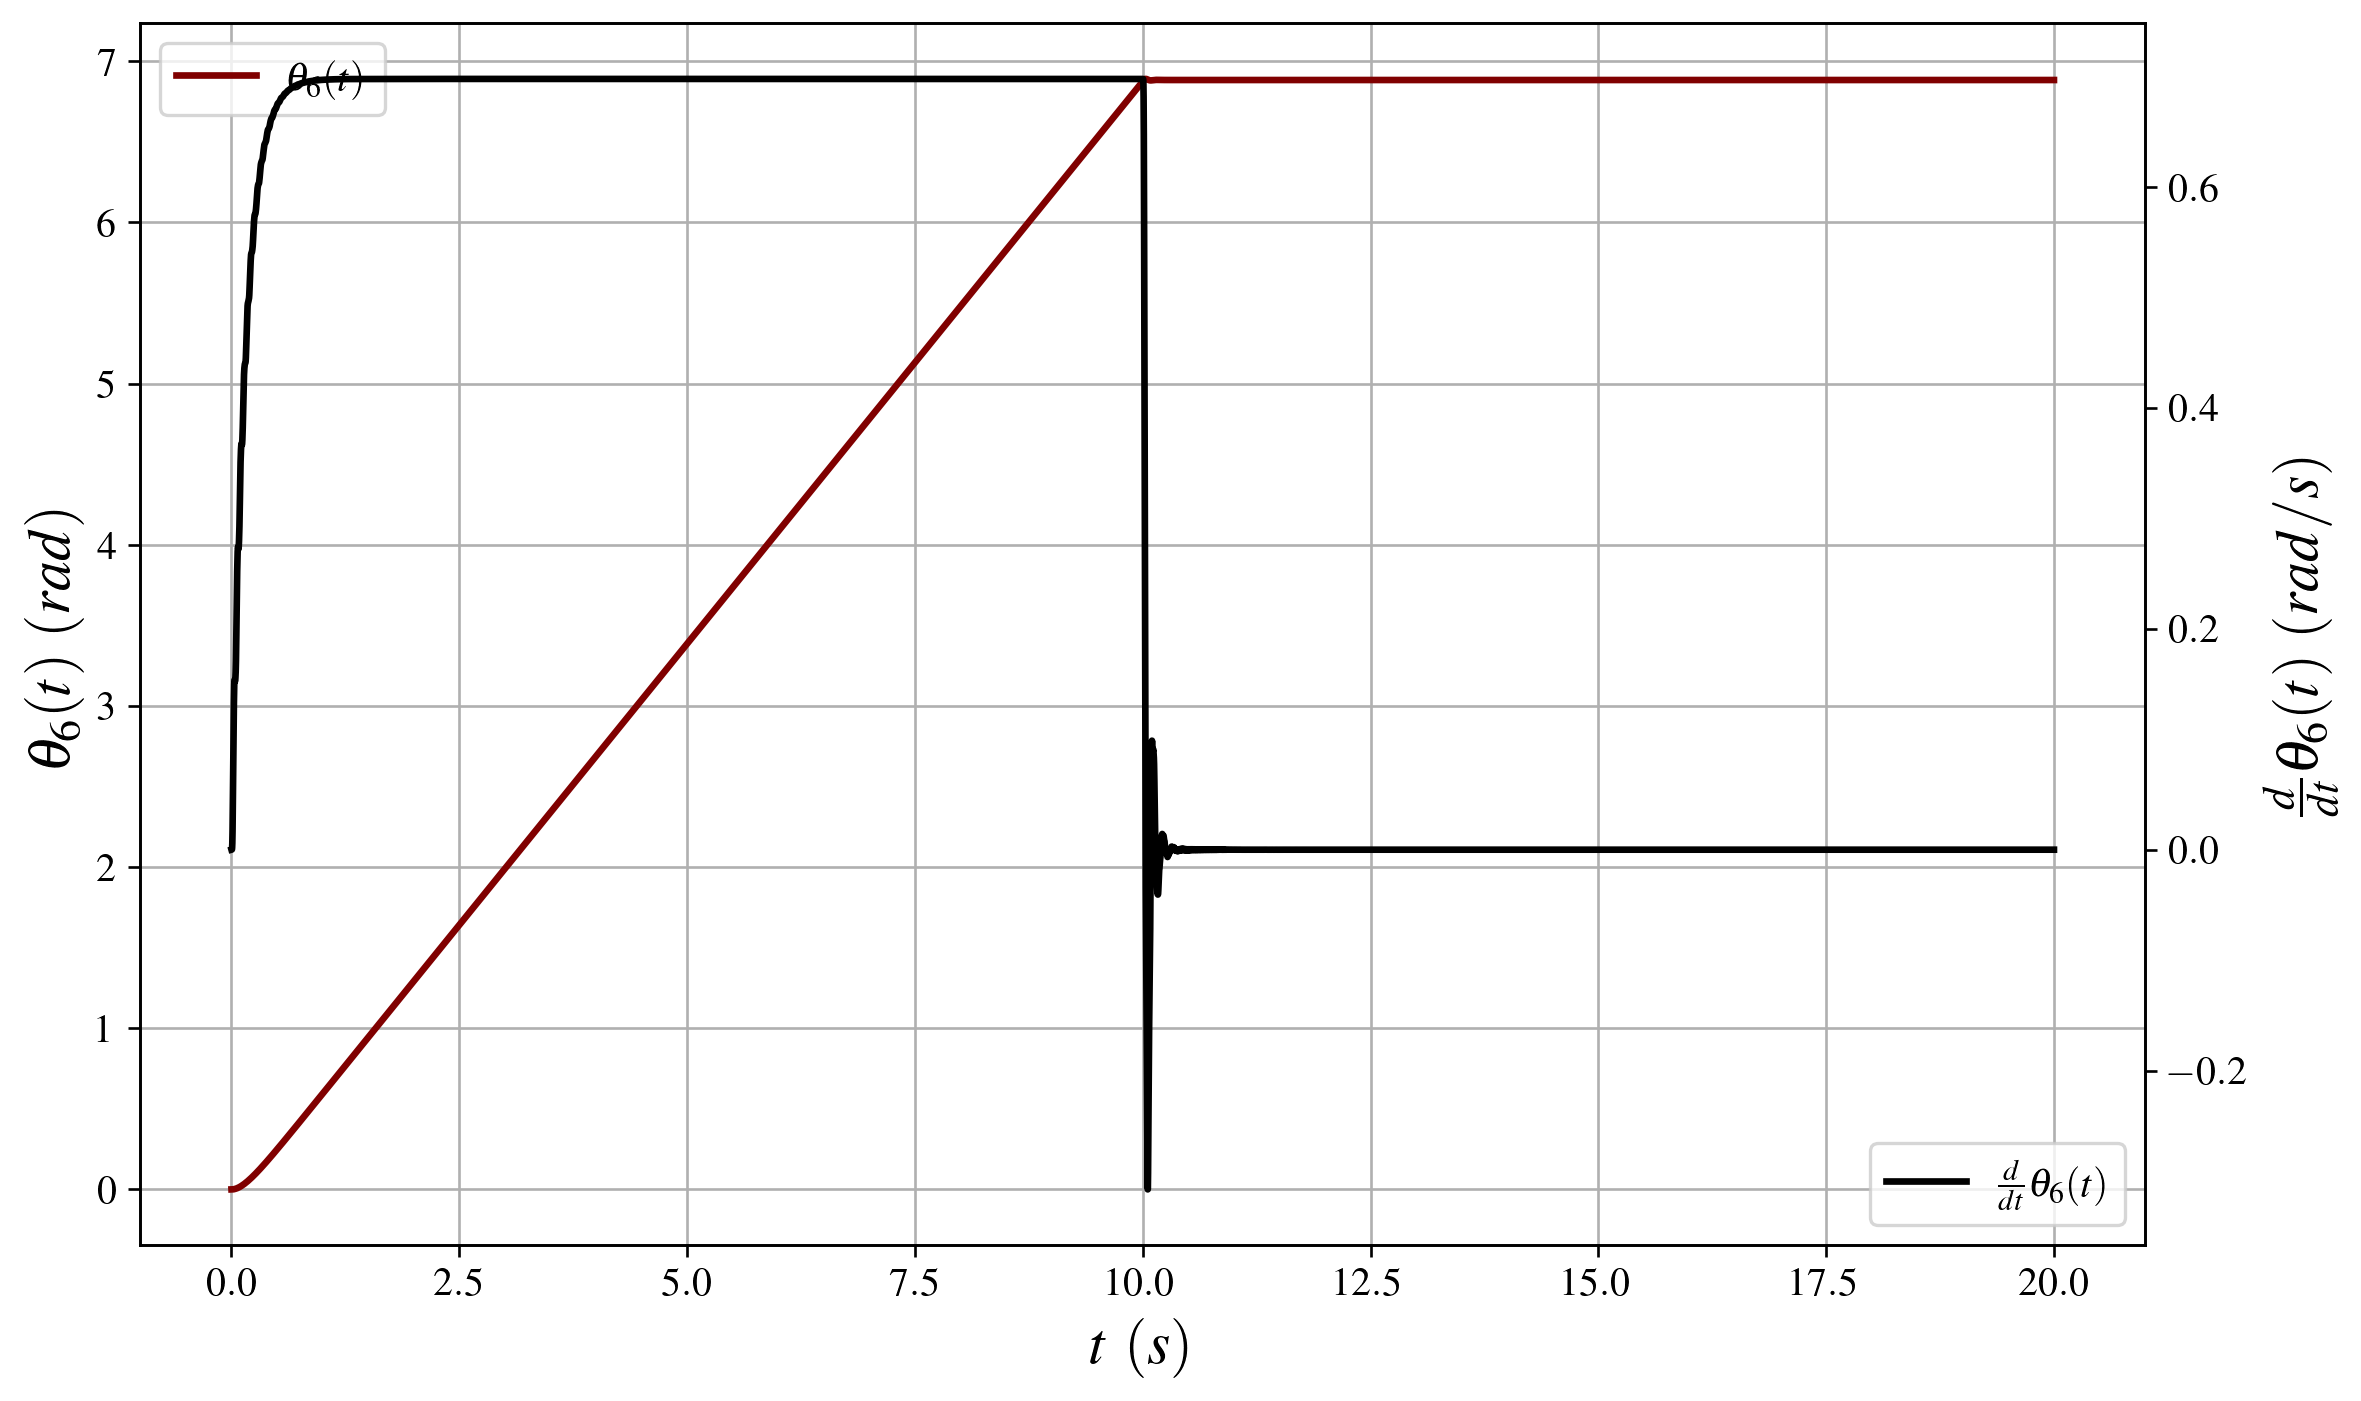

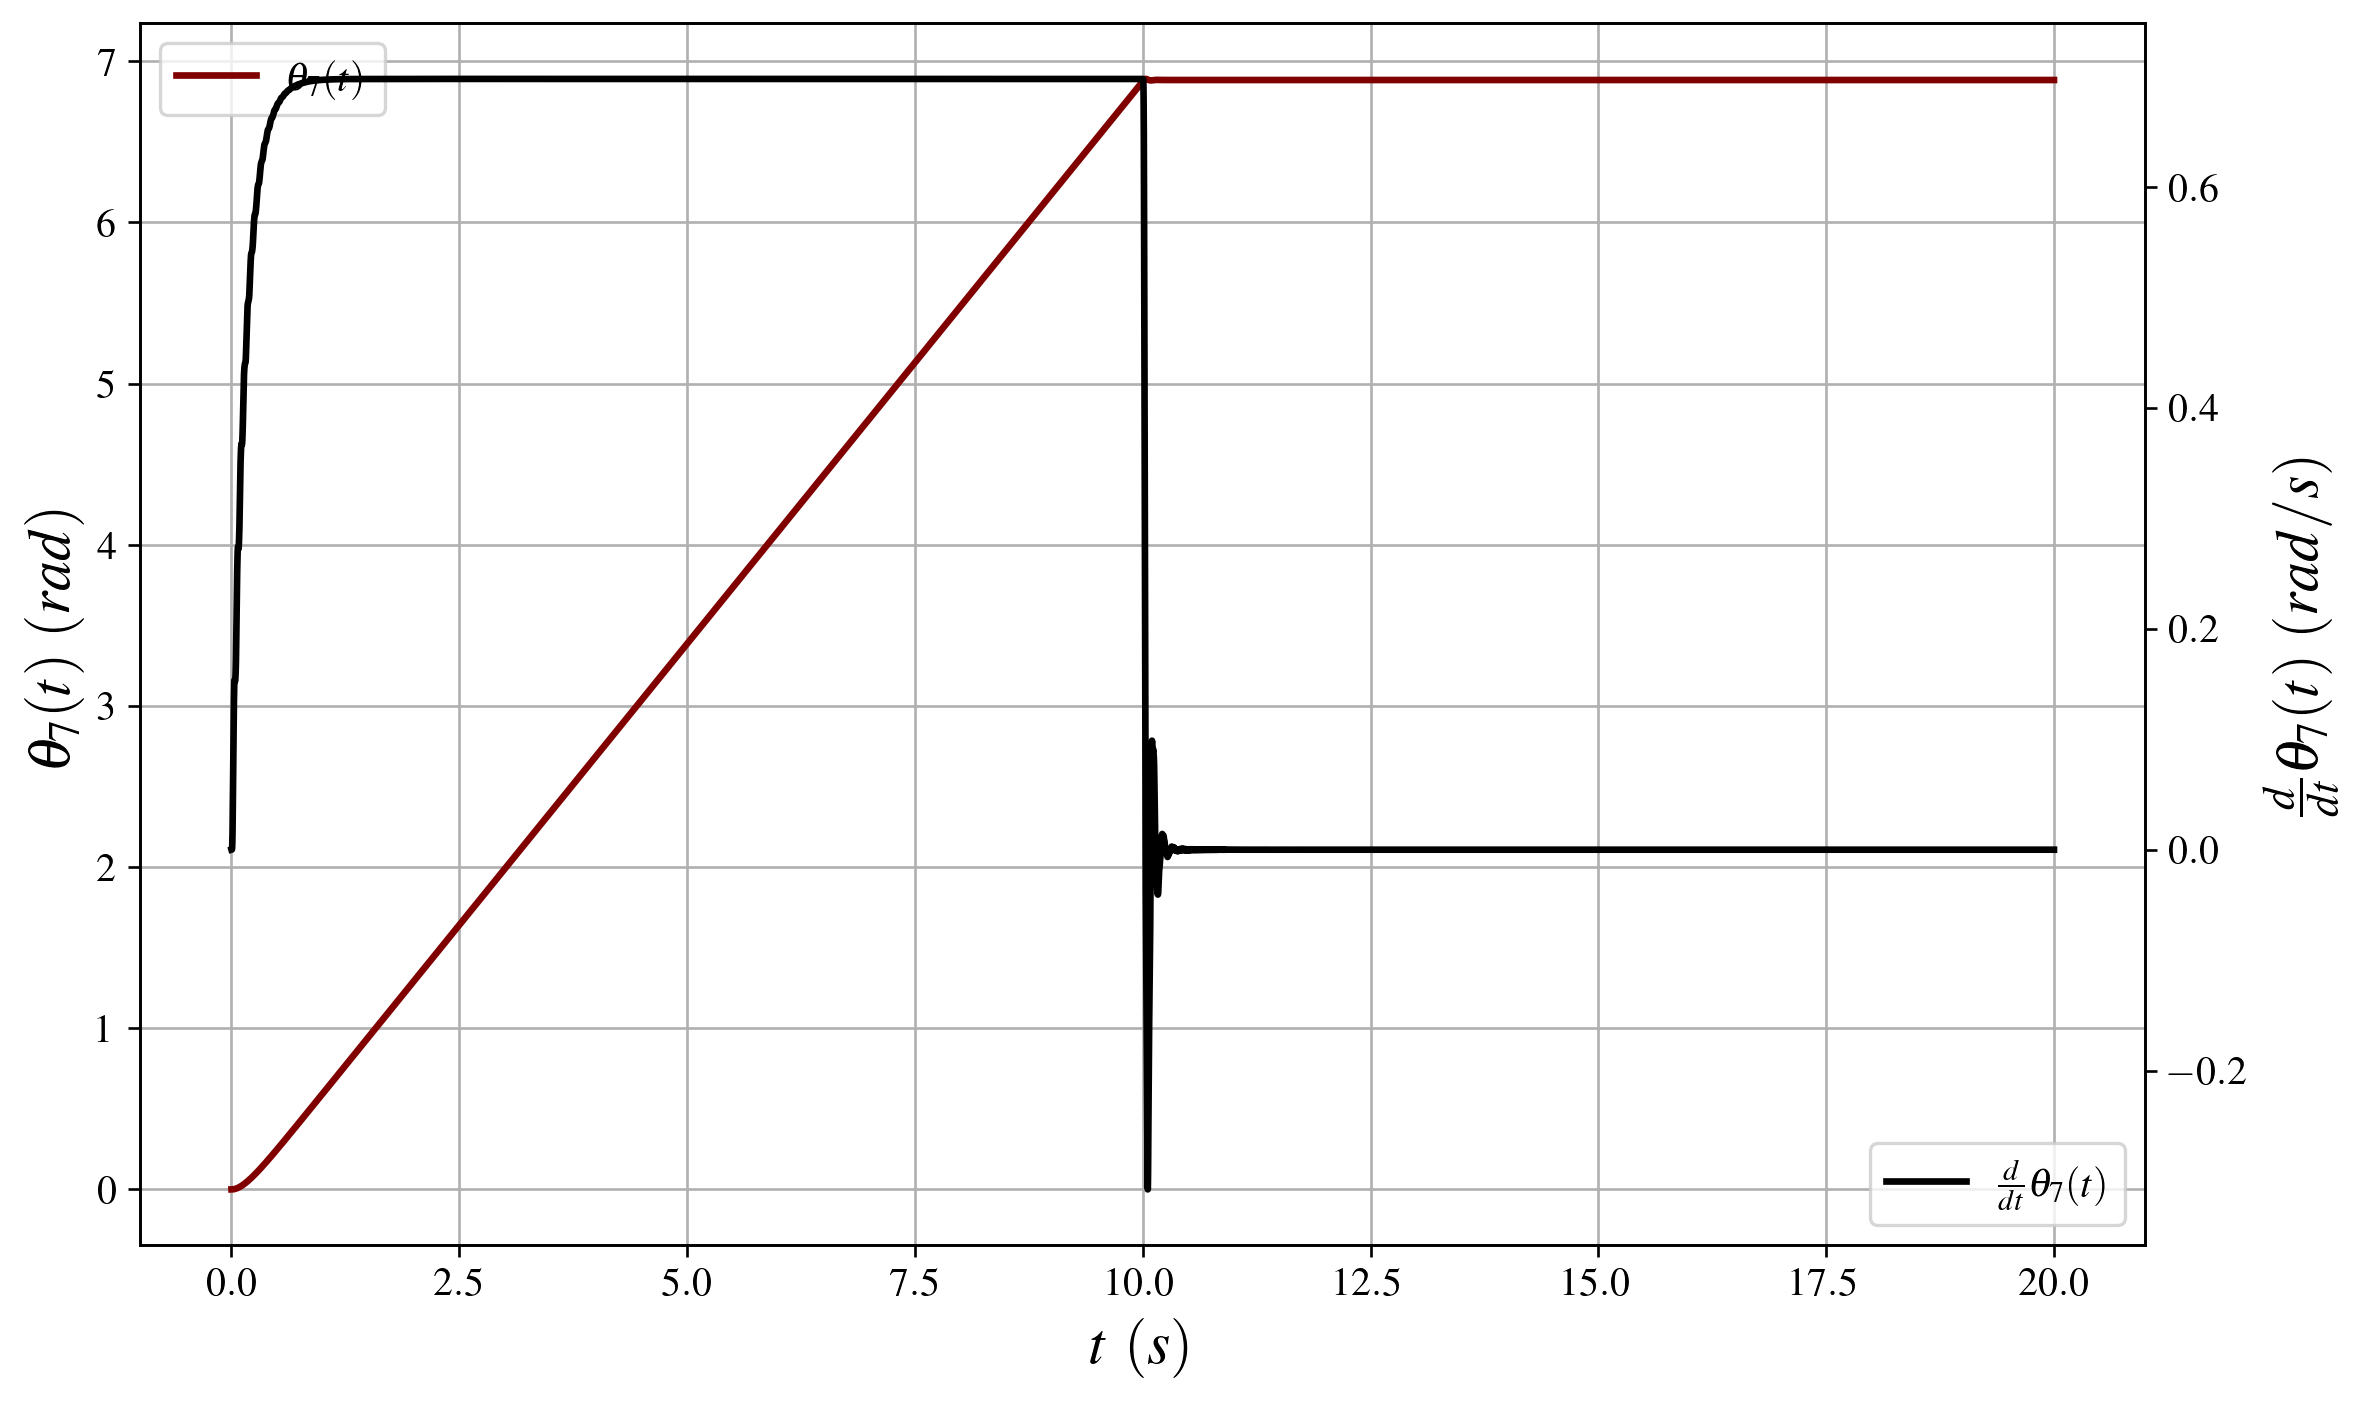

In [23]:
# Defining constants
# Interias in lbf*s^2*in
I0 = 0.2
I1, I2 = 0.05, 0.05
I3 = 0.1
I4, I5 = 0.5, 0.5
I6, I7 = 0.8, 0.8

# k1 and k2 lengths and diameters in inches
L1, D1 = 36, 0.75
L2, D2 = 40, 0.75

G = 1.15e7  # psi
k1 = (np.pi*(D1/2)**4*G)/(2*L1)  # lbf*in
k2 = (np.pi*(D2/2)**4*G)/(2*L2)  # lbf*in

B = 2880  # lbf*in*s

# Defining the input function
def Ma(w0, t_):
    return -315*w0 + 2000 if t_ < 10 else -14.4*w0

# Defining the state variable function
def state_vars(thetas, t_):
    x0, x2, x3, x6, x7, x8, x9, x10, x11, x12 = thetas
    return [
        x8,
        x9,
        x10,
        x11,
        x12,
        (Ma(x8, t_) - k1*x0 + k1*x2)/I0,
        k1*(x0 - 2*x2 + x3)/(I1 + I2),
        (9*k1*x2 - 9*k1*x3 - 2*k2*x3 + 3*k2*x6 + 3*k2*x7)/(9*I3 + I4 + I5),
        (k2/3*x3 - k2*x6 - B*x11)/I6,
        (k2/3*x3 - k2*x7 - B*x12)/I7
    ]

t_array = np.linspace(0, 20, 40_001)  # results in h = 0.0005
sol = odeint(state_vars, [0]*10, t_array)

for th, w in [(0, 5), (1, 6), (2, 7), (3, 8), (4, 9)]:
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    theta_label = sp.latex(state_eqs[th].lhs.args[0])
    omega_label = sp.latex(state_eqs[th].lhs)

    ax.plot(t_array, sol[:, th], label=f'${theta_label}$')
    ax2.plot(t_array, sol[:, w], label=f'${omega_label}$', color='black')

    ax2.grid(False)
    ax.legend()
    ax2.legend(loc='lower right')

    ax.set_xlabel('$t$ $(s)$')
    ax.set_ylabel(f'${theta_label}$ $(rad)$')
    ax2.set_ylabel(f'${omega_label}$ $(rad/s)$')

plt.show()

## Verification
### Part D
The results show that the motor velocity initially ramps up with an overshoot before arriving at a steady state value of $2.09424\,rad/s$. Upon the motor shutting off, and turning into a damper, the system arrives at rest in about $0.25\,s$. There is a great deal of ringing in this model, which is not good because this means that the transient responses have high accelerations or jerks that tend to cause premature failure from fatigue or even monotonic fracture. The best approach to fix this by ensuring that the motor's controller does not abruptly switch off. Instead, it can ramp down slower. Additionally, you can add more damping to the system, but this results in more energy loss.

At steady state, the motor is not operating at its maximum possible power (occurs at $\omega_0=3.17\,rad/s$). Instead, it delivers just enough power to balance the load and overcome damping. This operating point is determined by the load’s impedance and the inherent dynamics of the system, not by the maximum power available on the motor’s characteristic curve.
